# September 18 Meeting Notebook

This notebook is to categorize the exploration taken for the project as of September 18, 2025.

## Objectives

The objectives for this meeting are to:

1. Run the LSTM code for Fresno Agg. Data
2. Break down the feature vector into its components:
    - For each component, compare sliding window length for its comparison for VFRates.
3. Once (2) is completed, create a padding function and mask function that allows the new LSTM to take into account the individual sliding windows so see if analysis changes.

In [42]:
# load in the fresno aggregate data 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys 
import os 

sys.path.append(os.path.abspath('..')) 

df_fresno = pd.read_csv("../../data/Fresno_Aggregate.csv")

In [43]:
# print the head to make sure we have the right data loaded
df_fresno.head()

Year-Month    VFRate  FIRE_Acres_Burned  PRECIP  WIND_EventCount  \
0    2008-10  6.156349             163.91    0.18              0.0   
1    2008-11  3.407979              17.30    1.49              0.0   
2    2008-12  6.486154               0.00    1.19              0.0   
3    2009-01  6.619800               1.00    1.25              0.0   
4    2009-02  5.751629              28.00    2.33              0.0   

   WIND_AvgMPH  WIND_RunMiles  AQI_PM25  AQI_PM10  EARTHQUAKE_Total  \
0     3.667742      87.825806      70.0      53.0                 0   
1     3.106667      74.490000      95.5      38.5                 0   
2     3.306452      79.312903      94.0      18.5                 0   
3     2.587097      62.019355     102.0      33.0                 0   
4     3.928571      94.096429      51.5      13.0                 0   

   PESTICIDE_Total  
0        23.056051  
1         0.519323  
2         0.000000  
3        24.630400  
4        71.542885

In [44]:
from models import LSTM 

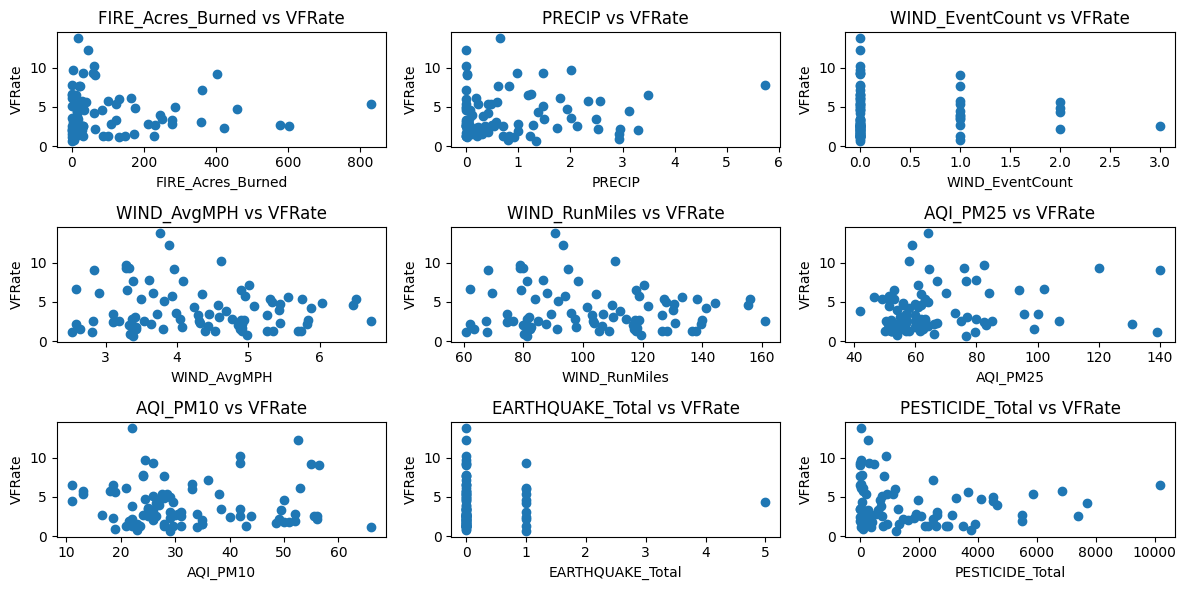

In [45]:
# Prepare features for LSTM
# Exclude 'Year-Month' and 'VFRate' (target variable)
feature_columns = ['FIRE_Acres_Burned', 'PRECIP', 'WIND_EventCount', 'WIND_AvgMPH', 
				  'WIND_RunMiles', 'AQI_PM25', 'AQI_PM10', 'EARTHQUAKE_Total', 'PESTICIDE_Total']

# Create X (features) and y (target)
X = df_fresno[feature_columns].values
y = df_fresno['VFRate'].values

# Plot correlation between features and VFRate
plt.figure(figsize=(12, 6))
for i, feature in enumerate(feature_columns):
	plt.subplot(3, 3, i+1)
	plt.scatter(df_fresno[feature], df_fresno['VFRate'])
	plt.xlabel(feature)
	plt.ylabel('VFRate')
	plt.title(f'{feature} vs VFRate')

plt.tight_layout()
plt.show()


In [46]:
# now what we want to do is loop through each feature and run the LSTM on each feature individually with a list of
# sliding window sizes and see which feature and sliding window size gives us the best performance
sliding_window_sizes = [1, 3, 6, 8, 12]
results = []

# probably need to make a function that preprocesses the "feature vector" for each run, turn into tensors
# test/train split, scale, and then run the LSTM model
def preprocess_data(X, y, feature_index, window_size, test_size=0.2):
  # Select the feature column
  if feature_index is not None:
    X_feature = X[:, feature_index].reshape(-1, 1)
  else:
    X_feature = X # its the whole feautre set

  # Create sequences for LSTM
  X_sequences, y_sequences = [], []
  for i in range(len(X_feature) - window_size):
    X_sequences.append(X_feature[i:i+window_size])
    y_sequences.append(y[i+window_size])

  X_sequences = np.array(X_sequences)
  y_sequences = np.array(y_sequences)

  # Train-test split
  split_index = int(len(X_sequences) * (1 - test_size))
  X_train, X_test = X_sequences[:split_index], X_sequences[split_index:]
  y_train, y_test = y_sequences[:split_index], y_sequences[split_index:]

  return X_train, X_test, y_train, y_test 

# before we plug into the lstm we need minmax scaling too
from sklearn.preprocessing import MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

def scale_data(X_train, X_test, y_train, y_test):
  # Reshape for scaling
  num_samples, window_size, num_features = X_train.shape
  X_train_reshaped = X_train.reshape(-1, num_features)
  X_test_reshaped = X_test.reshape(-1, num_features)

  # Scale features
  X_train_scaled = scaler_X.fit_transform(X_train_reshaped).reshape(num_samples, window_size, num_features)
  X_test_scaled = scaler_X.transform(X_test_reshaped).reshape(X_test.shape[0], window_size, num_features)

  # Scale target
  y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
  y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

  return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled

# below are model parameters 
# model parameters
# lookback has been removed because we are varying the sliding window size
hidden_size          = 32
num_layers           = 2
dropout              = 0.2
learning_rate        = 0.001
epochs               = 300
weight_decay         = 1e-5


In [47]:
# below is my training function for you to utilize 
import torch 
import numpy as np
import matplotlib.pyplot as plt 
from datetime import date

# Creating a Trainer Class to contain Training/Testing/Visualizing
class TrainerNewNew:
  """
  Trainer Class: A class that contains the training, testing, and visualization functions.
  """
  def __init__(self, model, criterion, optimizer, scaler):
    """
    Initialize the class. Takes in a model, crtierion for loss, optimizer, scaler.
    
    Inputs:
      - Model: Neural Network model
      - Criterion: Loss function (Typically MSELoss for time series, may look into more)
      - Optimizer: Optimizer with learning rate added. Typically using Adam
      - Scaler: MinMaxScaler scaler value, used for inverse transform to get actual data back
    """
    self.model     = model 
    self.criterion = criterion 
    self.optimizer = optimizer
    self.scaler    = scaler
  
  def train(self, X_train, y_train, X_test, y_test, epochs):
    history = {'train_loss': [], 'test_loss': []}

    for epoch in range(epochs):
        self.model.train()
        output = self.model(X_train)
        loss = self.criterion(output, y_train)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        history['train_loss'].append(loss.item())
        
        if epoch % 10 == 0:
            self.model.eval()
            with torch.no_grad():
                val_loss = self.criterion(self.model(X_test), y_test)
                history['test_loss'].append(val_loss.item())
                print(f"Epoch {epoch+1}/{epochs} - Training Loss {loss.item():.4f}, Testing Loss {val_loss.item():.4f}")
    
    # Capture the final training predictions
    self.model.eval()
    with torch.no_grad():
        final_train_preds = self.model(X_train).detach().cpu().numpy()
        
    # Also inverse transform the training data for later plotting
    y_train_true = self.scaler.inverse_transform(y_train.cpu().numpy().reshape(-1, 1)).flatten()
    final_train_preds_inv = self.scaler.inverse_transform(final_train_preds).flatten()
    
    return history, final_train_preds_inv, y_train_true
    
  def evaluate(self, X_test, y_test):
    """
    Evaluation Loop. Evaluates the model and generates predictions.

    Inputs:
      - X_test: Test matrix X
      - y_test: Test target vector y
    
    Outputs:
      - y_pred: predicted target vector from the model using X_test
      - y_true: True target vector (y_test)
    """
    self.model.eval()
    with torch.no_grad():
        preds = self.model(X_test).detach().cpu().numpy()

        # Inverse transform the predictions using the y_scaler
        # The y_scaler was fit on a 1-D array, so the predictions should be reshaped
        vf_pred = self.scaler.inverse_transform(preds)

        # Inverse transform the true values using the y_scaler
        # The y_scaler was fit on a 1-D array, so the true values should be reshaped
        vf_true = self.scaler.inverse_transform(y_test.cpu().numpy())
        
    return vf_pred.flatten(), vf_true.flatten()
  
  def visualize_results(self, true, pred, county_name="", model_type = "LSTM", title_text = "", show_plot = True, save_fig = False):
    """
    Function to visualize the prediction vs true (test) vector

    Inputs:
      - True: True data (test or validation target vector)
      - Pred: Prediction data from the model evaluation function
    """
    if show_plot:
      plt.figure(figsize=(12, 6))
      plt.plot(true, label="True Values")
      plt.plot(pred[1:], label = "Predicted Values", linestyle="--")
      plt.title(f"{county_name} {model_type} {title_text} True vs Predicted Valley Fever Case Rates")
      plt.xlabel("Months")
      plt.ylabel("Case Rates")
      plt.legend()
      plt.grid(True)
      plt.tight_layout()
      plt.show()
    
    if save_fig:
      plt.figure(figsize=(12, 6))
      plt.plot(true, label="True Values")
      plt.plot(pred[1:], label = "Predicted Values", linestyle="--")
      plt.title(f"{county_name} {model_type} {title_text} LSTM True vs Predicted Valley Fever Case Rates")
      plt.xlabel("Months")
      plt.ylabel("Case Rates")
      plt.legend()
      plt.grid(True)
      plt.tight_layout()
      img_str = f"Project/plots/{model_type}/{county_name}_{title_text}_plot_{date.today()}.png"
      plt.savefig(img_str)

In [48]:
from loss_functions import RMSELoss
import torch.optim as optim 

criterion = RMSELoss()

Epoch 1/300 - Training Loss 0.4899, Testing Loss 0.2514
Epoch 11/300 - Training Loss 0.4513, Testing Loss 0.2102
Epoch 21/300 - Training Loss 0.4113, Testing Loss 0.1681
Epoch 31/300 - Training Loss 0.3676, Testing Loss 0.1236
Epoch 41/300 - Training Loss 0.3175, Testing Loss 0.0829
Epoch 51/300 - Training Loss 0.2672, Testing Loss 0.0904
Epoch 61/300 - Training Loss 0.2272, Testing Loss 0.1640
Epoch 71/300 - Training Loss 0.2227, Testing Loss 0.2306
Epoch 81/300 - Training Loss 0.2145, Testing Loss 0.2298
Epoch 91/300 - Training Loss 0.2166, Testing Loss 0.2037
Epoch 101/300 - Training Loss 0.2211, Testing Loss 0.1952
Epoch 111/300 - Training Loss 0.2120, Testing Loss 0.2028
Epoch 121/300 - Training Loss 0.2173, Testing Loss 0.2085
Epoch 131/300 - Training Loss 0.2140, Testing Loss 0.2061
Epoch 141/300 - Training Loss 0.2129, Testing Loss 0.2026
Epoch 151/300 - Training Loss 0.2127, Testing Loss 0.2044
Epoch 161/300 - Training Loss 0.2105, Testing Loss 0.2072
Epoch 171/300 - Training 

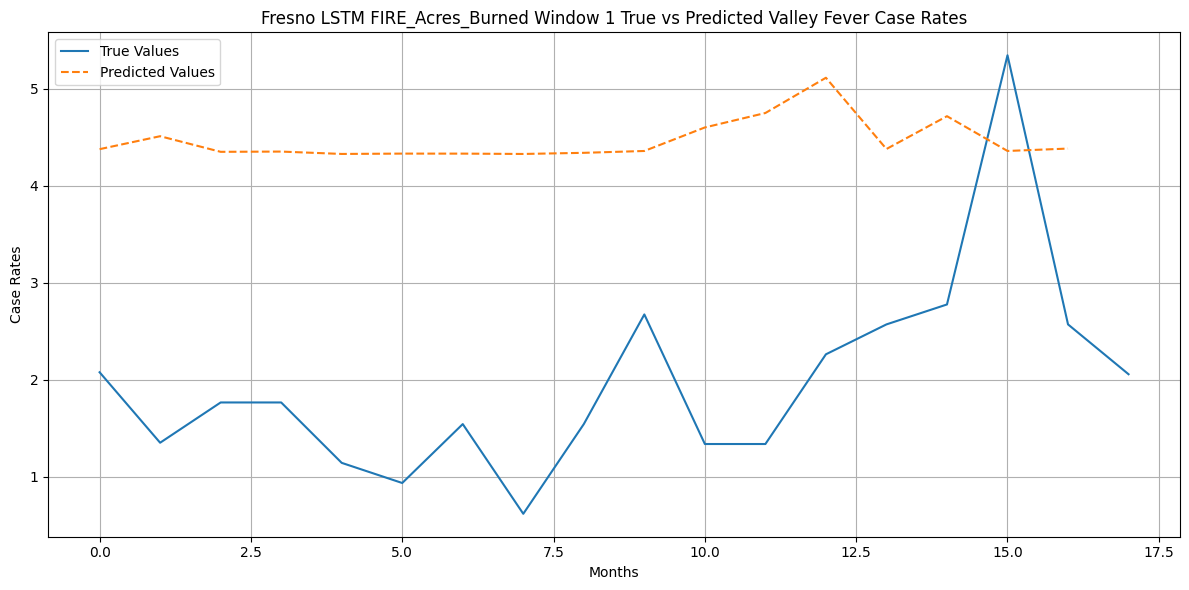

Epoch 1/300 - Training Loss 0.4221, Testing Loss 0.1769
Epoch 11/300 - Training Loss 0.3305, Testing Loss 0.0915
Epoch 21/300 - Training Loss 0.2467, Testing Loss 0.1171
Epoch 31/300 - Training Loss 0.2182, Testing Loss 0.2457
Epoch 41/300 - Training Loss 0.2195, Testing Loss 0.2337
Epoch 51/300 - Training Loss 0.2161, Testing Loss 0.1877
Epoch 61/300 - Training Loss 0.2143, Testing Loss 0.1981
Epoch 71/300 - Training Loss 0.2142, Testing Loss 0.2137
Epoch 81/300 - Training Loss 0.2110, Testing Loss 0.2051
Epoch 91/300 - Training Loss 0.2128, Testing Loss 0.2013
Epoch 101/300 - Training Loss 0.2123, Testing Loss 0.2042
Epoch 111/300 - Training Loss 0.2104, Testing Loss 0.2013
Epoch 121/300 - Training Loss 0.2097, Testing Loss 0.1980
Epoch 131/300 - Training Loss 0.2024, Testing Loss 0.1967
Epoch 141/300 - Training Loss 0.2057, Testing Loss 0.1900
Epoch 151/300 - Training Loss 0.2040, Testing Loss 0.1869
Epoch 161/300 - Training Loss 0.2022, Testing Loss 0.1805
Epoch 171/300 - Training 

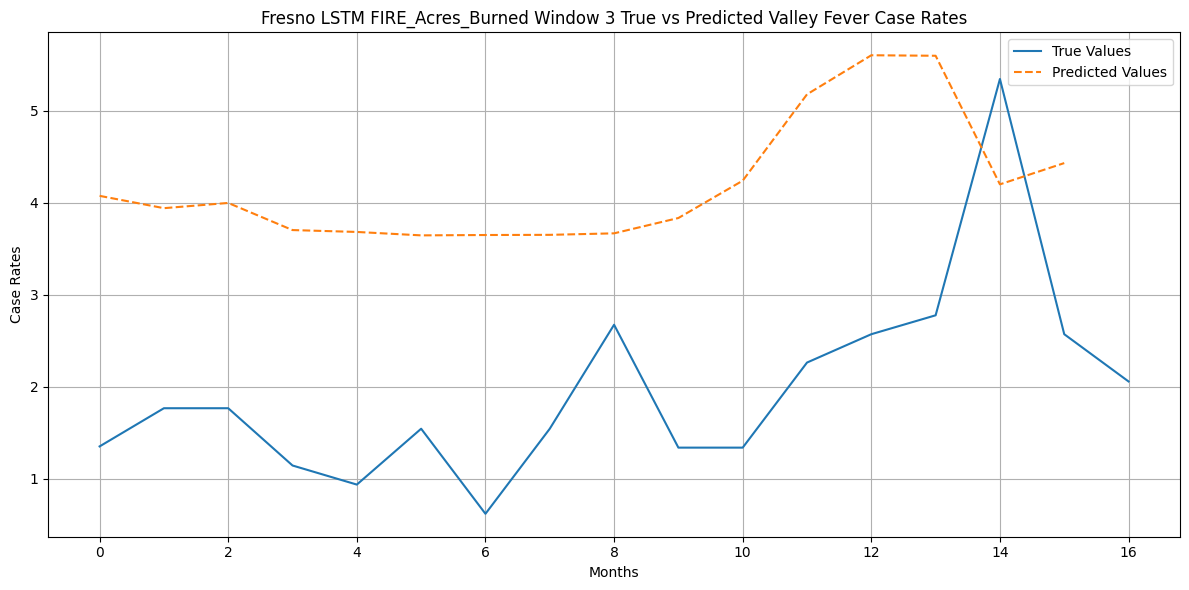

Epoch 1/300 - Training Loss 0.3700, Testing Loss 0.1246
Epoch 11/300 - Training Loss 0.2887, Testing Loss 0.0817
Epoch 21/300 - Training Loss 0.2263, Testing Loss 0.1788
Epoch 31/300 - Training Loss 0.2272, Testing Loss 0.2519
Epoch 41/300 - Training Loss 0.2211, Testing Loss 0.1914
Epoch 51/300 - Training Loss 0.2207, Testing Loss 0.1900
Epoch 61/300 - Training Loss 0.2180, Testing Loss 0.2120
Epoch 71/300 - Training Loss 0.2157, Testing Loss 0.2003
Epoch 81/300 - Training Loss 0.2120, Testing Loss 0.1964
Epoch 91/300 - Training Loss 0.2034, Testing Loss 0.1908
Epoch 101/300 - Training Loss 0.1989, Testing Loss 0.1757
Epoch 111/300 - Training Loss 0.1927, Testing Loss 0.1486
Epoch 121/300 - Training Loss 0.1921, Testing Loss 0.1475
Epoch 131/300 - Training Loss 0.1860, Testing Loss 0.1520
Epoch 141/300 - Training Loss 0.1889, Testing Loss 0.1435
Epoch 151/300 - Training Loss 0.1869, Testing Loss 0.1386
Epoch 161/300 - Training Loss 0.1843, Testing Loss 0.1403
Epoch 171/300 - Training 

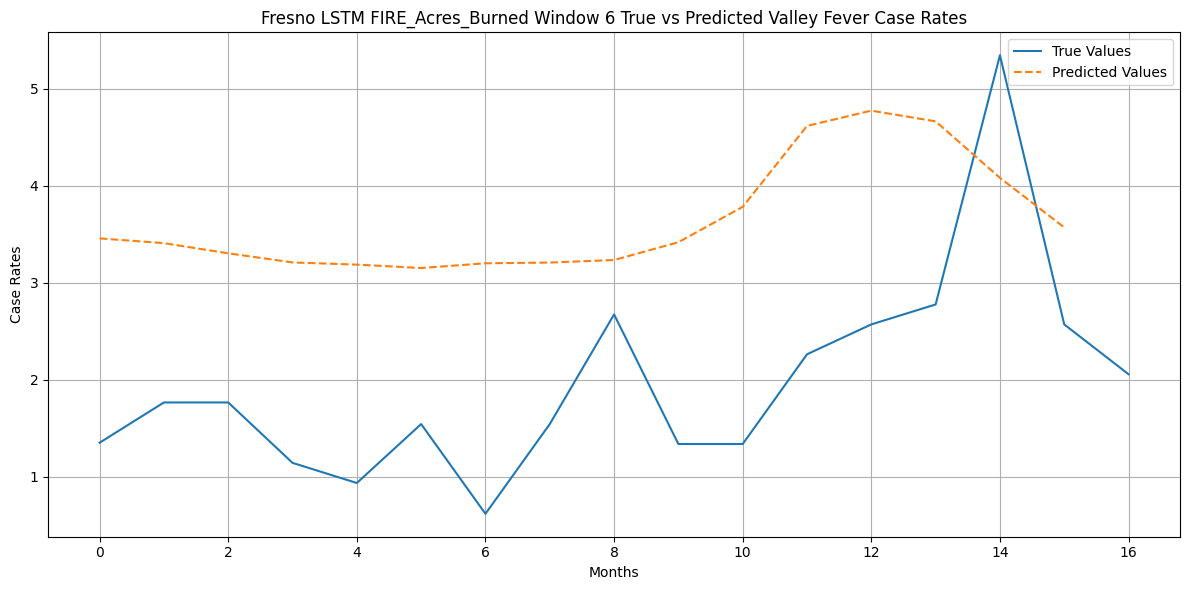

Epoch 1/300 - Training Loss 0.4089, Testing Loss 0.1689
Epoch 11/300 - Training Loss 0.3107, Testing Loss 0.0835
Epoch 21/300 - Training Loss 0.2294, Testing Loss 0.1813
Epoch 31/300 - Training Loss 0.2304, Testing Loss 0.2416
Epoch 41/300 - Training Loss 0.2244, Testing Loss 0.1727
Epoch 51/300 - Training Loss 0.2207, Testing Loss 0.1900
Epoch 61/300 - Training Loss 0.2226, Testing Loss 0.2077
Epoch 71/300 - Training Loss 0.2214, Testing Loss 0.1900
Epoch 81/300 - Training Loss 0.2186, Testing Loss 0.1937
Epoch 91/300 - Training Loss 0.2185, Testing Loss 0.1923
Epoch 101/300 - Training Loss 0.2152, Testing Loss 0.1843
Epoch 111/300 - Training Loss 0.2046, Testing Loss 0.1739
Epoch 121/300 - Training Loss 0.1995, Testing Loss 0.1459
Epoch 131/300 - Training Loss 0.1938, Testing Loss 0.1203
Epoch 141/300 - Training Loss 0.1872, Testing Loss 0.1208
Epoch 151/300 - Training Loss 0.1854, Testing Loss 0.1179
Epoch 161/300 - Training Loss 0.1806, Testing Loss 0.1168
Epoch 171/300 - Training 

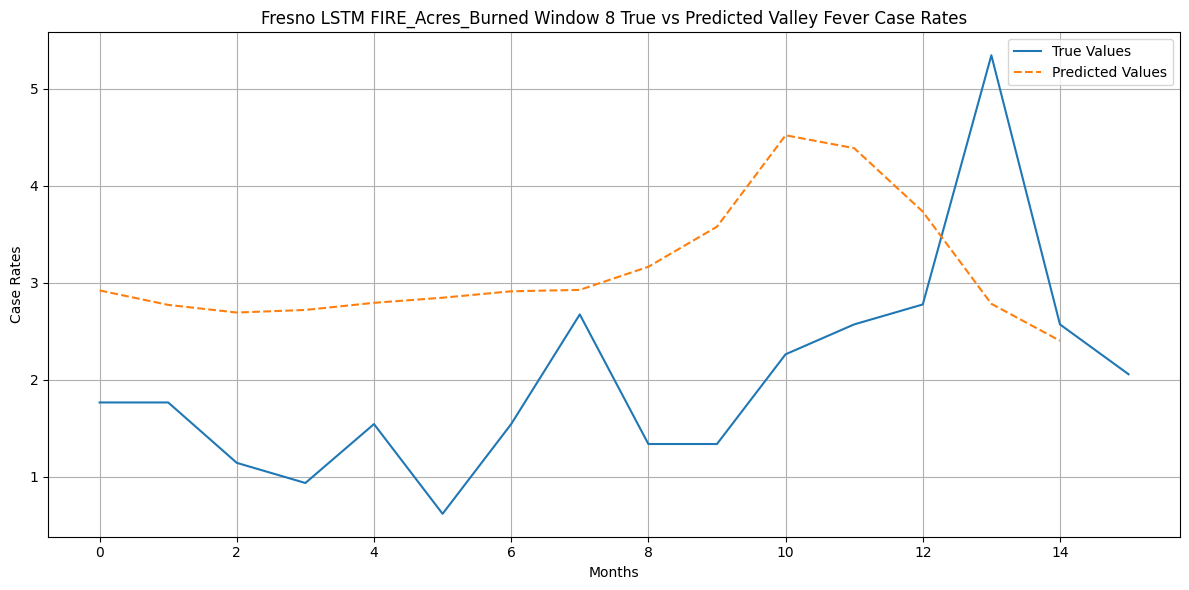

Epoch 1/300 - Training Loss 0.2446, Testing Loss 0.1465
Epoch 11/300 - Training Loss 0.2328, Testing Loss 0.2195
Epoch 21/300 - Training Loss 0.2321, Testing Loss 0.1814
Epoch 31/300 - Training Loss 0.2305, Testing Loss 0.2041
Epoch 41/300 - Training Loss 0.2297, Testing Loss 0.1882
Epoch 51/300 - Training Loss 0.2272, Testing Loss 0.1941
Epoch 61/300 - Training Loss 0.2204, Testing Loss 0.1808
Epoch 71/300 - Training Loss 0.2100, Testing Loss 0.1519
Epoch 81/300 - Training Loss 0.1963, Testing Loss 0.0894
Epoch 91/300 - Training Loss 0.1873, Testing Loss 0.0947
Epoch 101/300 - Training Loss 0.1861, Testing Loss 0.1014
Epoch 111/300 - Training Loss 0.1743, Testing Loss 0.0963
Epoch 121/300 - Training Loss 0.1808, Testing Loss 0.0922
Epoch 131/300 - Training Loss 0.1708, Testing Loss 0.0840
Epoch 141/300 - Training Loss 0.1720, Testing Loss 0.0826
Epoch 151/300 - Training Loss 0.1681, Testing Loss 0.0763
Epoch 161/300 - Training Loss 0.1616, Testing Loss 0.0779
Epoch 171/300 - Training 

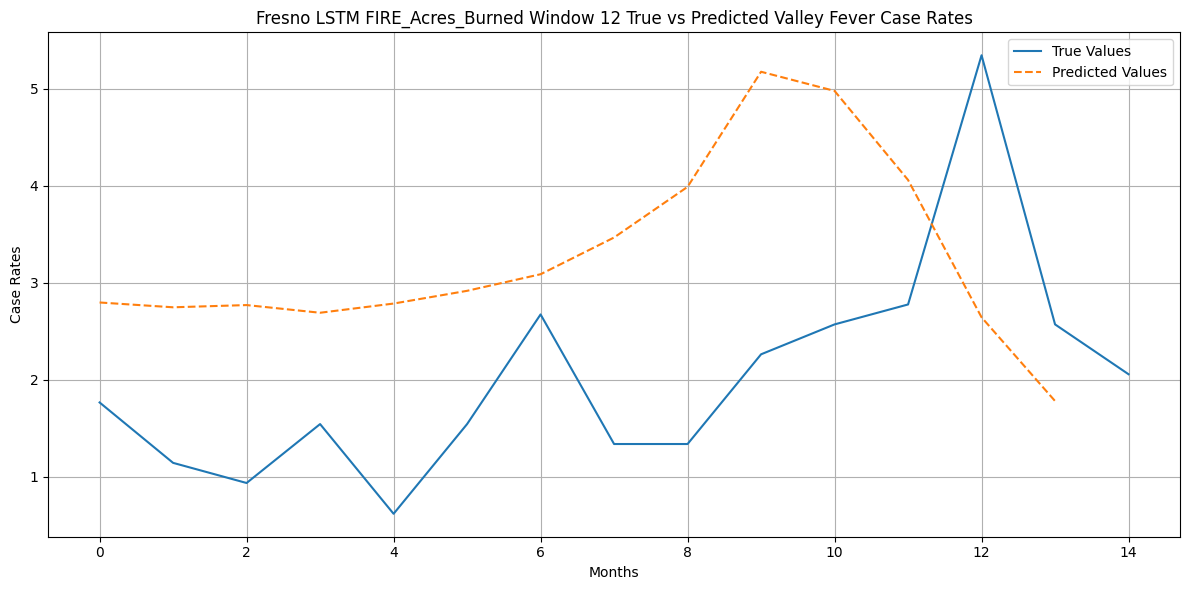

Epoch 1/300 - Training Loss 0.4133, Testing Loss 0.1709
Epoch 11/300 - Training Loss 0.3807, Testing Loss 0.1377
Epoch 21/300 - Training Loss 0.3471, Testing Loss 0.1059
Epoch 31/300 - Training Loss 0.3108, Testing Loss 0.0816
Epoch 41/300 - Training Loss 0.2711, Testing Loss 0.0884
Epoch 51/300 - Training Loss 0.2341, Testing Loss 0.1396
Epoch 61/300 - Training Loss 0.2201, Testing Loss 0.2073
Epoch 71/300 - Training Loss 0.2198, Testing Loss 0.2352
Epoch 81/300 - Training Loss 0.2189, Testing Loss 0.2170
Epoch 91/300 - Training Loss 0.2202, Testing Loss 0.2015
Epoch 101/300 - Training Loss 0.2181, Testing Loss 0.2021
Epoch 111/300 - Training Loss 0.2194, Testing Loss 0.2081
Epoch 121/300 - Training Loss 0.2182, Testing Loss 0.2105
Epoch 131/300 - Training Loss 0.2147, Testing Loss 0.2089
Epoch 141/300 - Training Loss 0.2206, Testing Loss 0.2085
Epoch 151/300 - Training Loss 0.2194, Testing Loss 0.2094
Epoch 161/300 - Training Loss 0.2199, Testing Loss 0.2095
Epoch 171/300 - Training 

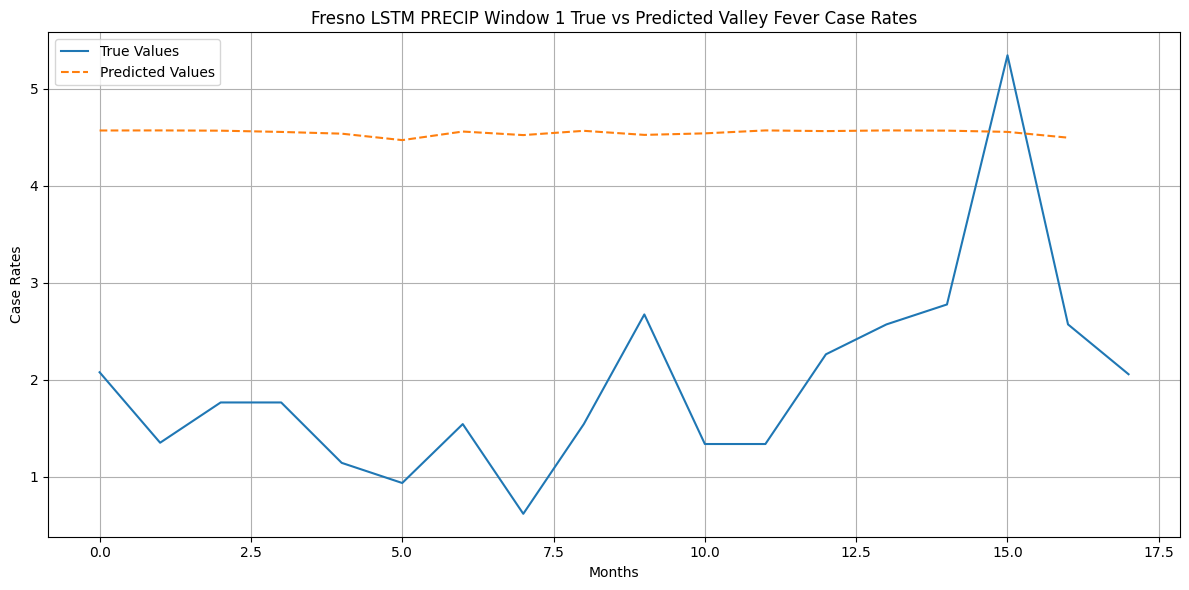

Epoch 1/300 - Training Loss 0.3432, Testing Loss 0.1019
Epoch 11/300 - Training Loss 0.2740, Testing Loss 0.0892
Epoch 21/300 - Training Loss 0.2220, Testing Loss 0.1802
Epoch 31/300 - Training Loss 0.2239, Testing Loss 0.2511
Epoch 41/300 - Training Loss 0.2196, Testing Loss 0.2087
Epoch 51/300 - Training Loss 0.2196, Testing Loss 0.1922
Epoch 61/300 - Training Loss 0.2182, Testing Loss 0.2076
Epoch 71/300 - Training Loss 0.2189, Testing Loss 0.2141
Epoch 81/300 - Training Loss 0.2202, Testing Loss 0.2072
Epoch 91/300 - Training Loss 0.2188, Testing Loss 0.2061
Epoch 101/300 - Training Loss 0.2196, Testing Loss 0.2089
Epoch 111/300 - Training Loss 0.2175, Testing Loss 0.2095
Epoch 121/300 - Training Loss 0.2194, Testing Loss 0.2099
Epoch 131/300 - Training Loss 0.2176, Testing Loss 0.2104
Epoch 141/300 - Training Loss 0.2166, Testing Loss 0.2107
Epoch 151/300 - Training Loss 0.2173, Testing Loss 0.2110
Epoch 161/300 - Training Loss 0.2183, Testing Loss 0.2110
Epoch 171/300 - Training 

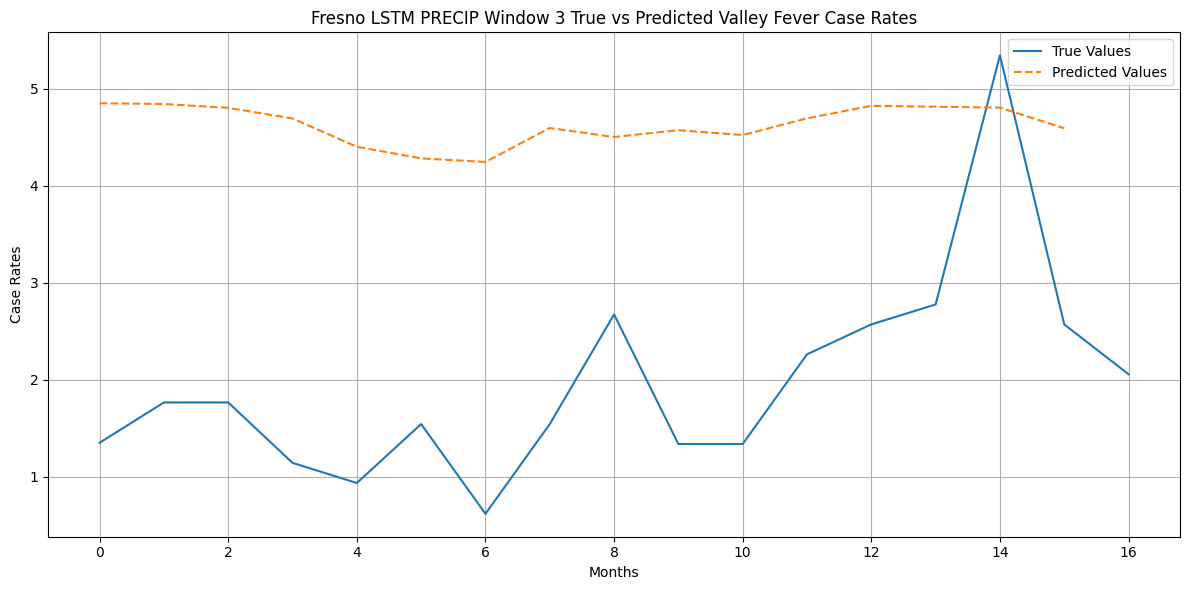

Epoch 1/300 - Training Loss 0.2456, Testing Loss 0.1271
Epoch 11/300 - Training Loss 0.2234, Testing Loss 0.2335
Epoch 21/300 - Training Loss 0.2217, Testing Loss 0.2091
Epoch 31/300 - Training Loss 0.2220, Testing Loss 0.1930
Epoch 41/300 - Training Loss 0.2223, Testing Loss 0.2101
Epoch 51/300 - Training Loss 0.2220, Testing Loss 0.2076
Epoch 61/300 - Training Loss 0.2224, Testing Loss 0.2029
Epoch 71/300 - Training Loss 0.2212, Testing Loss 0.2076
Epoch 81/300 - Training Loss 0.2217, Testing Loss 0.2054
Epoch 91/300 - Training Loss 0.2216, Testing Loss 0.2054
Epoch 101/300 - Training Loss 0.2218, Testing Loss 0.2062
Epoch 111/300 - Training Loss 0.2216, Testing Loss 0.2052
Epoch 121/300 - Training Loss 0.2209, Testing Loss 0.2052
Epoch 131/300 - Training Loss 0.2208, Testing Loss 0.2051
Epoch 141/300 - Training Loss 0.2209, Testing Loss 0.2040
Epoch 151/300 - Training Loss 0.2197, Testing Loss 0.2025
Epoch 161/300 - Training Loss 0.2185, Testing Loss 0.1967
Epoch 171/300 - Training 

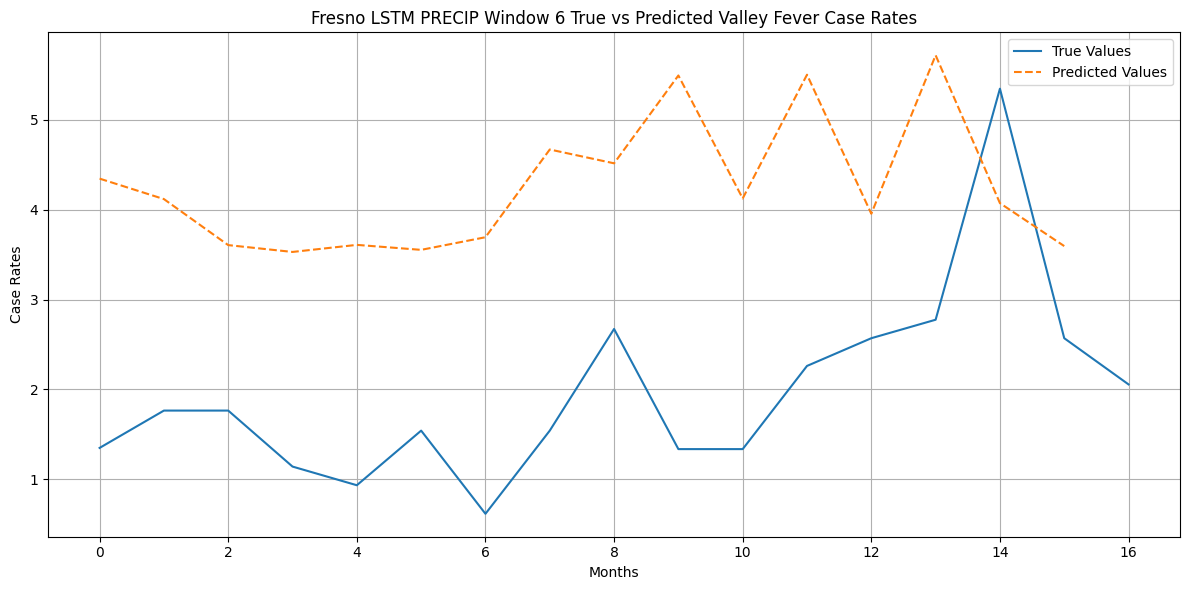

Epoch 1/300 - Training Loss 0.3588, Testing Loss 0.1204
Epoch 11/300 - Training Loss 0.2796, Testing Loss 0.0873
Epoch 21/300 - Training Loss 0.2269, Testing Loss 0.2387
Epoch 31/300 - Training Loss 0.2257, Testing Loss 0.2060
Epoch 41/300 - Training Loss 0.2263, Testing Loss 0.1727
Epoch 51/300 - Training Loss 0.2244, Testing Loss 0.2035
Epoch 61/300 - Training Loss 0.2248, Testing Loss 0.2031
Epoch 71/300 - Training Loss 0.2246, Testing Loss 0.1924
Epoch 81/300 - Training Loss 0.2241, Testing Loss 0.1994
Epoch 91/300 - Training Loss 0.2248, Testing Loss 0.1975
Epoch 101/300 - Training Loss 0.2230, Testing Loss 0.1958
Epoch 111/300 - Training Loss 0.2217, Testing Loss 0.1967
Epoch 121/300 - Training Loss 0.2200, Testing Loss 0.1935
Epoch 131/300 - Training Loss 0.2140, Testing Loss 0.1858
Epoch 141/300 - Training Loss 0.2090, Testing Loss 0.1735
Epoch 151/300 - Training Loss 0.2016, Testing Loss 0.1650
Epoch 161/300 - Training Loss 0.1979, Testing Loss 0.1660
Epoch 171/300 - Training 

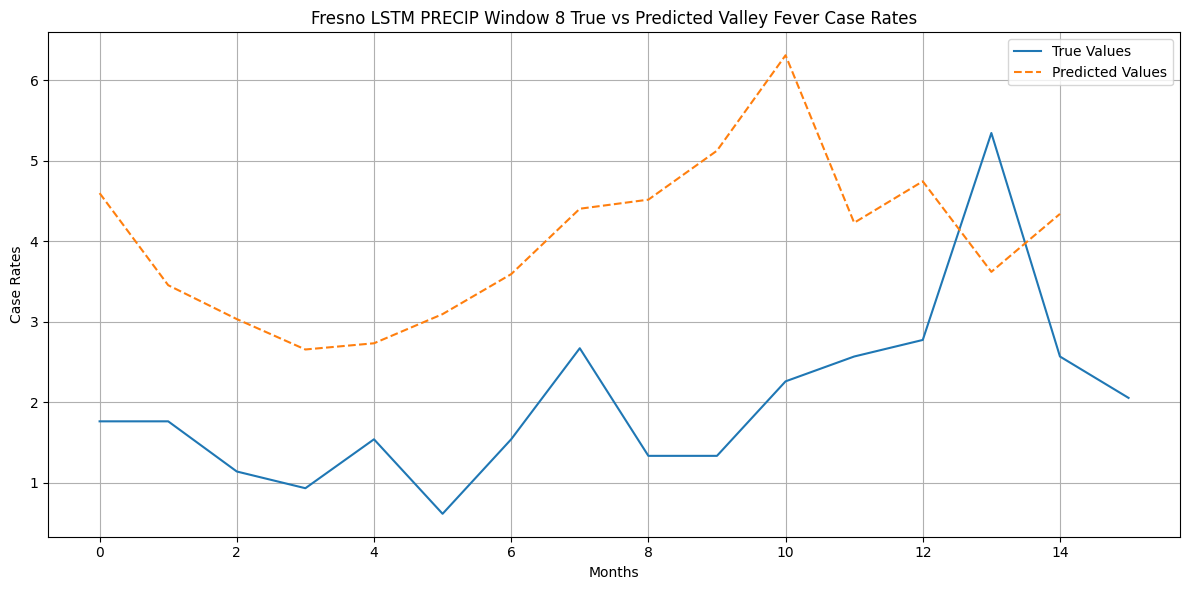

Epoch 1/300 - Training Loss 0.3627, Testing Loss 0.1200
Epoch 11/300 - Training Loss 0.2605, Testing Loss 0.1176
Epoch 21/300 - Training Loss 0.2443, Testing Loss 0.2597
Epoch 31/300 - Training Loss 0.2321, Testing Loss 0.1807
Epoch 41/300 - Training Loss 0.2323, Testing Loss 0.1810
Epoch 51/300 - Training Loss 0.2305, Testing Loss 0.2077
Epoch 61/300 - Training Loss 0.2297, Testing Loss 0.1961
Epoch 71/300 - Training Loss 0.2319, Testing Loss 0.1942
Epoch 81/300 - Training Loss 0.2294, Testing Loss 0.1993
Epoch 91/300 - Training Loss 0.2304, Testing Loss 0.1954
Epoch 101/300 - Training Loss 0.2298, Testing Loss 0.1974
Epoch 111/300 - Training Loss 0.2249, Testing Loss 0.1942
Epoch 121/300 - Training Loss 0.2020, Testing Loss 0.1778
Epoch 131/300 - Training Loss 0.1623, Testing Loss 0.0697
Epoch 141/300 - Training Loss 0.1519, Testing Loss 0.0839
Epoch 151/300 - Training Loss 0.1474, Testing Loss 0.0635
Epoch 161/300 - Training Loss 0.1447, Testing Loss 0.0677
Epoch 171/300 - Training 

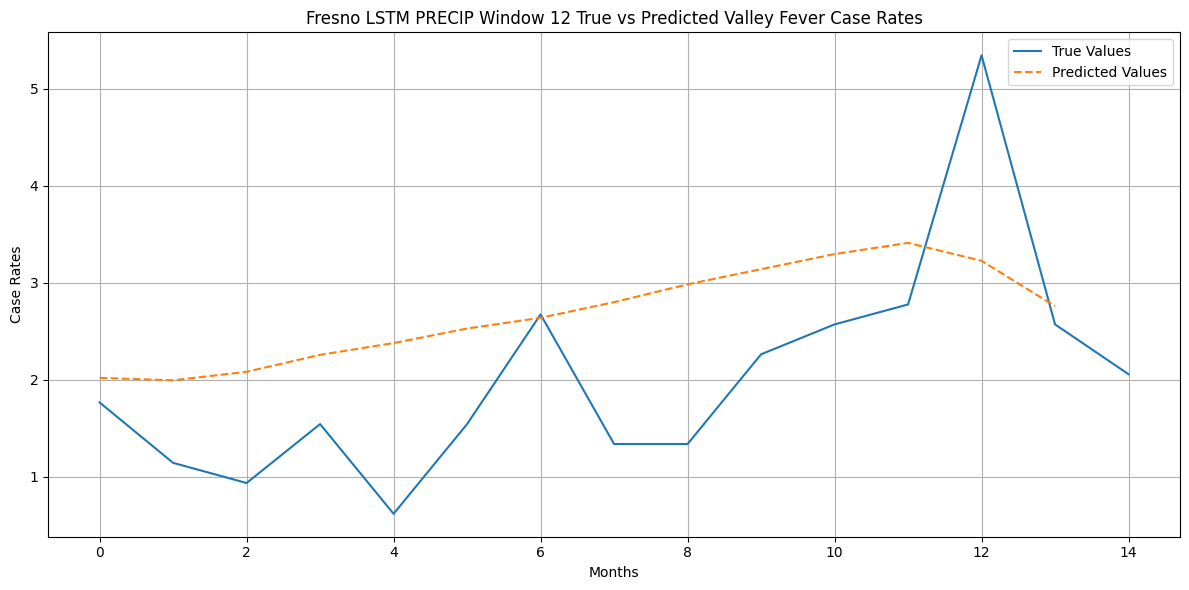

Epoch 1/300 - Training Loss 0.3181, Testing Loss 0.0846
Epoch 11/300 - Training Loss 0.2852, Testing Loss 0.0795
Epoch 21/300 - Training Loss 0.2555, Testing Loss 0.1016
Epoch 31/300 - Training Loss 0.2323, Testing Loss 0.1427
Epoch 41/300 - Training Loss 0.2185, Testing Loss 0.1907
Epoch 51/300 - Training Loss 0.2182, Testing Loss 0.2232
Epoch 61/300 - Training Loss 0.2173, Testing Loss 0.2228
Epoch 71/300 - Training Loss 0.2160, Testing Loss 0.2107
Epoch 81/300 - Training Loss 0.2159, Testing Loss 0.2059
Epoch 91/300 - Training Loss 0.2168, Testing Loss 0.2083
Epoch 101/300 - Training Loss 0.2155, Testing Loss 0.2128
Epoch 111/300 - Training Loss 0.2168, Testing Loss 0.2141
Epoch 121/300 - Training Loss 0.2148, Testing Loss 0.2138
Epoch 131/300 - Training Loss 0.2142, Testing Loss 0.2131
Epoch 141/300 - Training Loss 0.2151, Testing Loss 0.2138
Epoch 151/300 - Training Loss 0.2160, Testing Loss 0.2154
Epoch 161/300 - Training Loss 0.2155, Testing Loss 0.2159
Epoch 171/300 - Training 

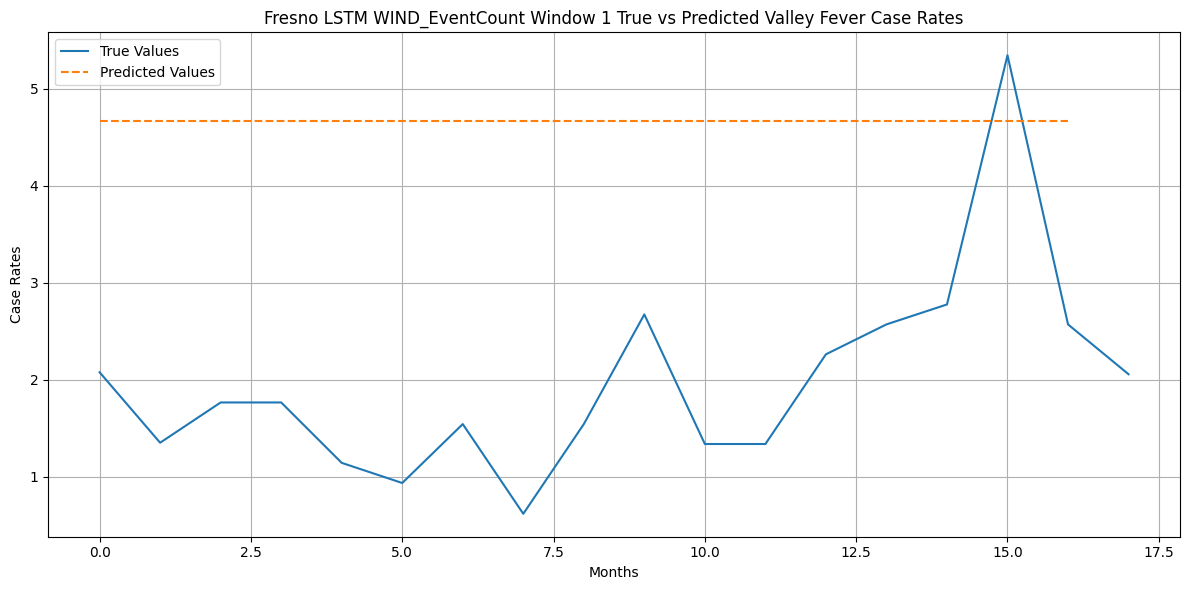

Epoch 1/300 - Training Loss 0.2822, Testing Loss 0.0838
Epoch 11/300 - Training Loss 0.2347, Testing Loss 0.1408
Epoch 21/300 - Training Loss 0.2181, Testing Loss 0.2253
Epoch 31/300 - Training Loss 0.2194, Testing Loss 0.2324
Epoch 41/300 - Training Loss 0.2186, Testing Loss 0.2027
Epoch 51/300 - Training Loss 0.2184, Testing Loss 0.2020
Epoch 61/300 - Training Loss 0.2187, Testing Loss 0.2135
Epoch 71/300 - Training Loss 0.2190, Testing Loss 0.2140
Epoch 81/300 - Training Loss 0.2177, Testing Loss 0.2097
Epoch 91/300 - Training Loss 0.2181, Testing Loss 0.2126
Epoch 101/300 - Training Loss 0.2169, Testing Loss 0.2149
Epoch 111/300 - Training Loss 0.2183, Testing Loss 0.2134
Epoch 121/300 - Training Loss 0.2176, Testing Loss 0.2143
Epoch 131/300 - Training Loss 0.2170, Testing Loss 0.2161
Epoch 141/300 - Training Loss 0.2173, Testing Loss 0.2157
Epoch 151/300 - Training Loss 0.2172, Testing Loss 0.2155
Epoch 161/300 - Training Loss 0.2169, Testing Loss 0.2179
Epoch 171/300 - Training 

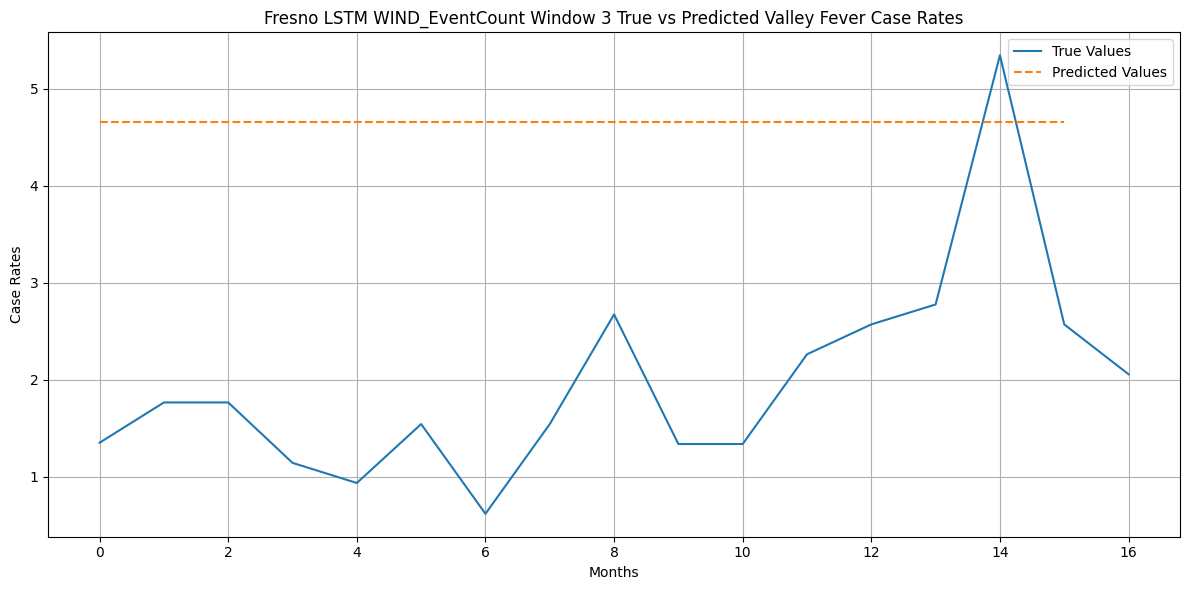

Epoch 1/300 - Training Loss 0.2745, Testing Loss 0.0919
Epoch 11/300 - Training Loss 0.2221, Testing Loss 0.2173
Epoch 21/300 - Training Loss 0.2241, Testing Loss 0.2301
Epoch 31/300 - Training Loss 0.2225, Testing Loss 0.1899
Epoch 41/300 - Training Loss 0.2218, Testing Loss 0.2037
Epoch 51/300 - Training Loss 0.2219, Testing Loss 0.2144
Epoch 61/300 - Training Loss 0.2221, Testing Loss 0.2048
Epoch 71/300 - Training Loss 0.2219, Testing Loss 0.2072
Epoch 81/300 - Training Loss 0.2219, Testing Loss 0.2102
Epoch 91/300 - Training Loss 0.2209, Testing Loss 0.2084
Epoch 101/300 - Training Loss 0.2205, Testing Loss 0.2099
Epoch 111/300 - Training Loss 0.2223, Testing Loss 0.2105
Epoch 121/300 - Training Loss 0.2226, Testing Loss 0.2118
Epoch 131/300 - Training Loss 0.2211, Testing Loss 0.2129
Epoch 141/300 - Training Loss 0.2213, Testing Loss 0.2136
Epoch 151/300 - Training Loss 0.2226, Testing Loss 0.2152
Epoch 161/300 - Training Loss 0.2222, Testing Loss 0.2157
Epoch 171/300 - Training 

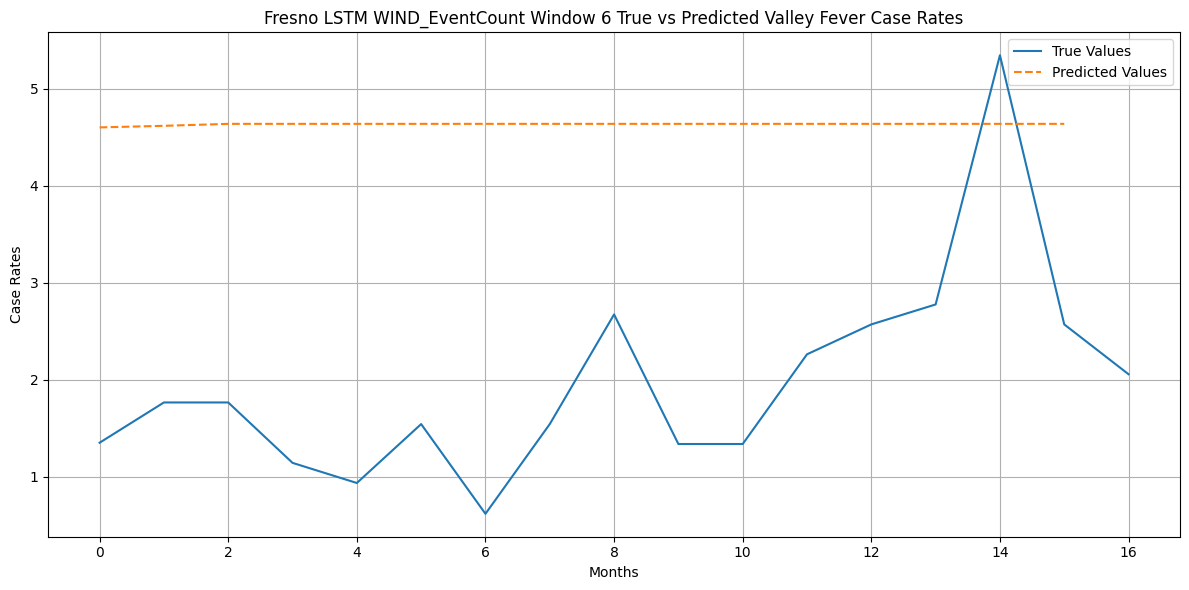

Epoch 1/300 - Training Loss 0.4480, Testing Loss 0.2105
Epoch 11/300 - Training Loss 0.3376, Testing Loss 0.0986
Epoch 21/300 - Training Loss 0.2293, Testing Loss 0.1956
Epoch 31/300 - Training Loss 0.2300, Testing Loss 0.2243
Epoch 41/300 - Training Loss 0.2286, Testing Loss 0.1609
Epoch 51/300 - Training Loss 0.2258, Testing Loss 0.2006
Epoch 61/300 - Training Loss 0.2255, Testing Loss 0.2035
Epoch 71/300 - Training Loss 0.2253, Testing Loss 0.1888
Epoch 81/300 - Training Loss 0.2261, Testing Loss 0.2006
Epoch 91/300 - Training Loss 0.2262, Testing Loss 0.1976
Epoch 101/300 - Training Loss 0.2243, Testing Loss 0.1966
Epoch 111/300 - Training Loss 0.2251, Testing Loss 0.1998
Epoch 121/300 - Training Loss 0.2258, Testing Loss 0.1991
Epoch 131/300 - Training Loss 0.2221, Testing Loss 0.2009
Epoch 141/300 - Training Loss 0.2243, Testing Loss 0.1996
Epoch 151/300 - Training Loss 0.2245, Testing Loss 0.2020
Epoch 161/300 - Training Loss 0.2255, Testing Loss 0.2002
Epoch 171/300 - Training 

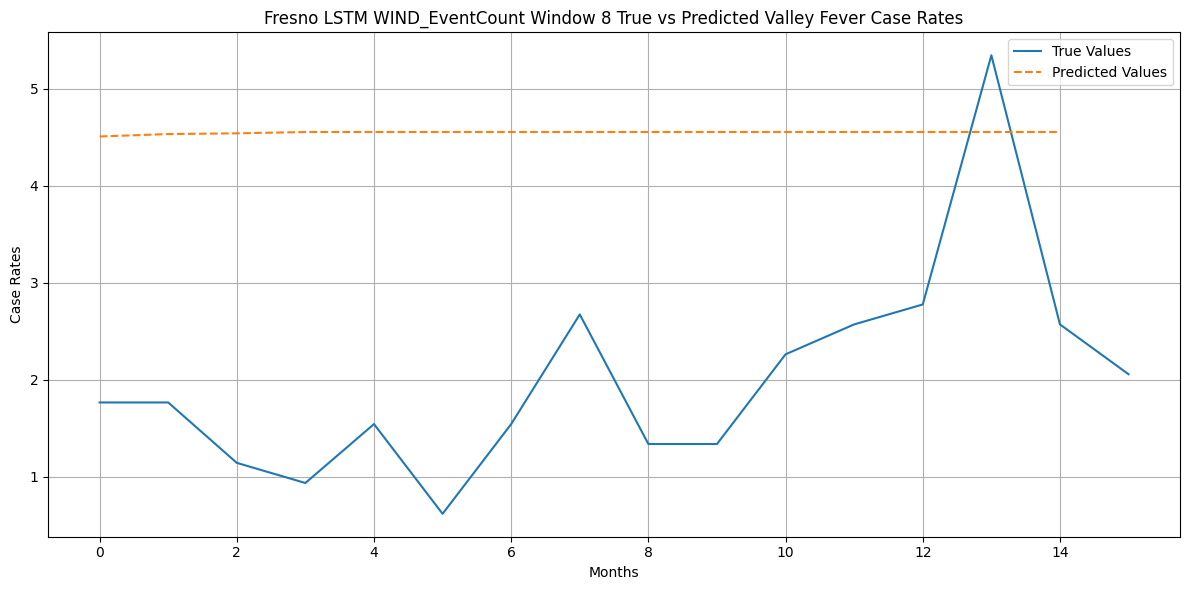

Epoch 1/300 - Training Loss 0.2662, Testing Loss 0.1036
Epoch 11/300 - Training Loss 0.2321, Testing Loss 0.2163
Epoch 21/300 - Training Loss 0.2318, Testing Loss 0.2090
Epoch 31/300 - Training Loss 0.2326, Testing Loss 0.1824
Epoch 41/300 - Training Loss 0.2315, Testing Loss 0.1971
Epoch 51/300 - Training Loss 0.2323, Testing Loss 0.2039
Epoch 61/300 - Training Loss 0.2318, Testing Loss 0.1957
Epoch 71/300 - Training Loss 0.2323, Testing Loss 0.1985
Epoch 81/300 - Training Loss 0.2311, Testing Loss 0.2009
Epoch 91/300 - Training Loss 0.2319, Testing Loss 0.1991
Epoch 101/300 - Training Loss 0.2316, Testing Loss 0.2010
Epoch 111/300 - Training Loss 0.2314, Testing Loss 0.2012
Epoch 121/300 - Training Loss 0.2327, Testing Loss 0.2024
Epoch 131/300 - Training Loss 0.2311, Testing Loss 0.2030
Epoch 141/300 - Training Loss 0.2316, Testing Loss 0.2039
Epoch 151/300 - Training Loss 0.2313, Testing Loss 0.2052
Epoch 161/300 - Training Loss 0.2313, Testing Loss 0.2054
Epoch 171/300 - Training 

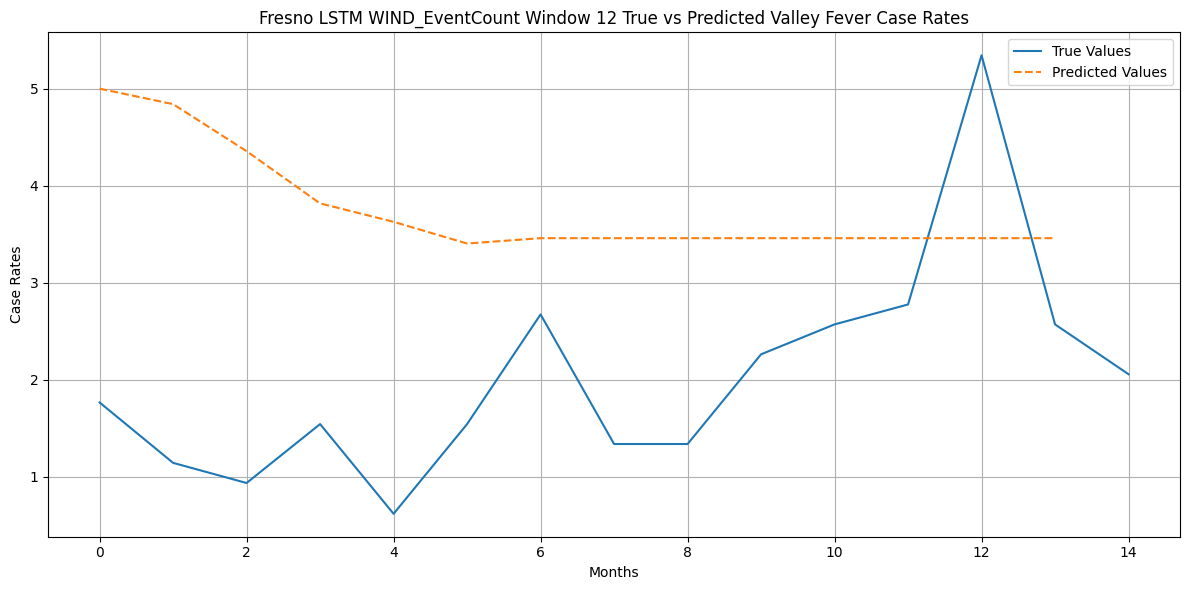

Epoch 1/300 - Training Loss 0.2620, Testing Loss 0.0944
Epoch 11/300 - Training Loss 0.2398, Testing Loss 0.1252
Epoch 21/300 - Training Loss 0.2248, Testing Loss 0.1614
Epoch 31/300 - Training Loss 0.2178, Testing Loss 0.1967
Epoch 41/300 - Training Loss 0.2169, Testing Loss 0.2193
Epoch 51/300 - Training Loss 0.2186, Testing Loss 0.2205
Epoch 61/300 - Training Loss 0.2160, Testing Loss 0.2120
Epoch 71/300 - Training Loss 0.2161, Testing Loss 0.2076
Epoch 81/300 - Training Loss 0.2164, Testing Loss 0.2083
Epoch 91/300 - Training Loss 0.2161, Testing Loss 0.2109
Epoch 101/300 - Training Loss 0.2165, Testing Loss 0.2118
Epoch 111/300 - Training Loss 0.2159, Testing Loss 0.2115
Epoch 121/300 - Training Loss 0.2164, Testing Loss 0.2107
Epoch 131/300 - Training Loss 0.2155, Testing Loss 0.2108
Epoch 141/300 - Training Loss 0.2177, Testing Loss 0.2123
Epoch 151/300 - Training Loss 0.2165, Testing Loss 0.2122
Epoch 161/300 - Training Loss 0.2160, Testing Loss 0.2121
Epoch 171/300 - Training 

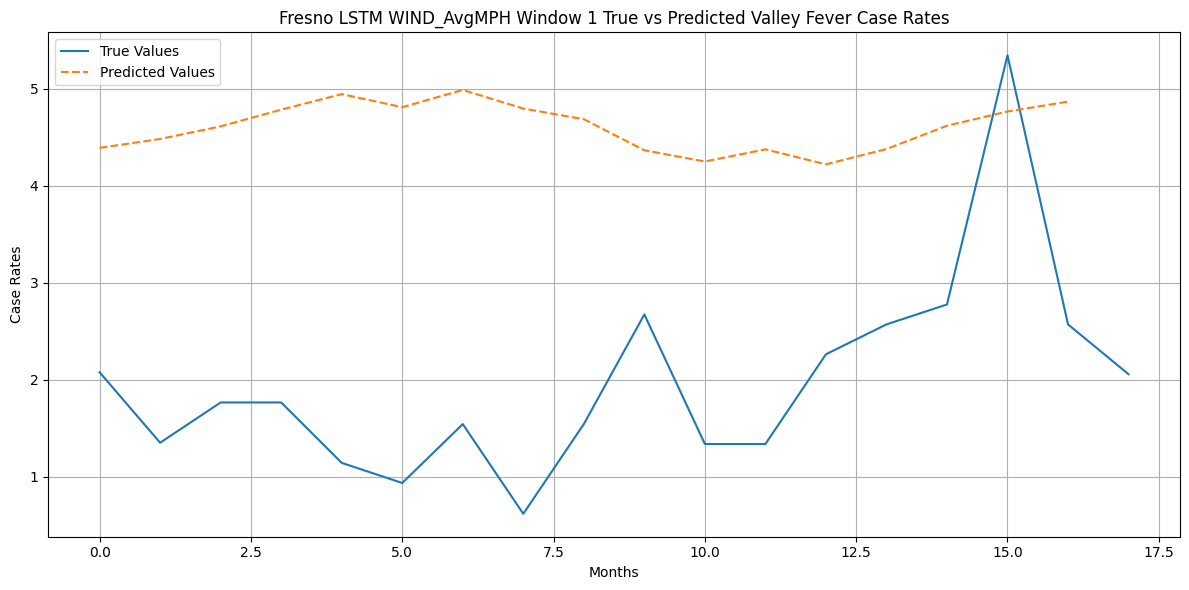

Epoch 1/300 - Training Loss 0.4306, Testing Loss 0.1872
Epoch 11/300 - Training Loss 0.3469, Testing Loss 0.1046
Epoch 21/300 - Training Loss 0.2639, Testing Loss 0.1015
Epoch 31/300 - Training Loss 0.2230, Testing Loss 0.2450
Epoch 41/300 - Training Loss 0.2221, Testing Loss 0.2317
Epoch 51/300 - Training Loss 0.2220, Testing Loss 0.1847
Epoch 61/300 - Training Loss 0.2171, Testing Loss 0.1997
Epoch 71/300 - Training Loss 0.2194, Testing Loss 0.2159
Epoch 81/300 - Training Loss 0.2191, Testing Loss 0.2062
Epoch 91/300 - Training Loss 0.2208, Testing Loss 0.2037
Epoch 101/300 - Training Loss 0.2221, Testing Loss 0.2079
Epoch 111/300 - Training Loss 0.2176, Testing Loss 0.2083
Epoch 121/300 - Training Loss 0.2185, Testing Loss 0.2060
Epoch 131/300 - Training Loss 0.2171, Testing Loss 0.2083
Epoch 141/300 - Training Loss 0.2173, Testing Loss 0.2066
Epoch 151/300 - Training Loss 0.2207, Testing Loss 0.2067
Epoch 161/300 - Training Loss 0.2208, Testing Loss 0.2075
Epoch 171/300 - Training 

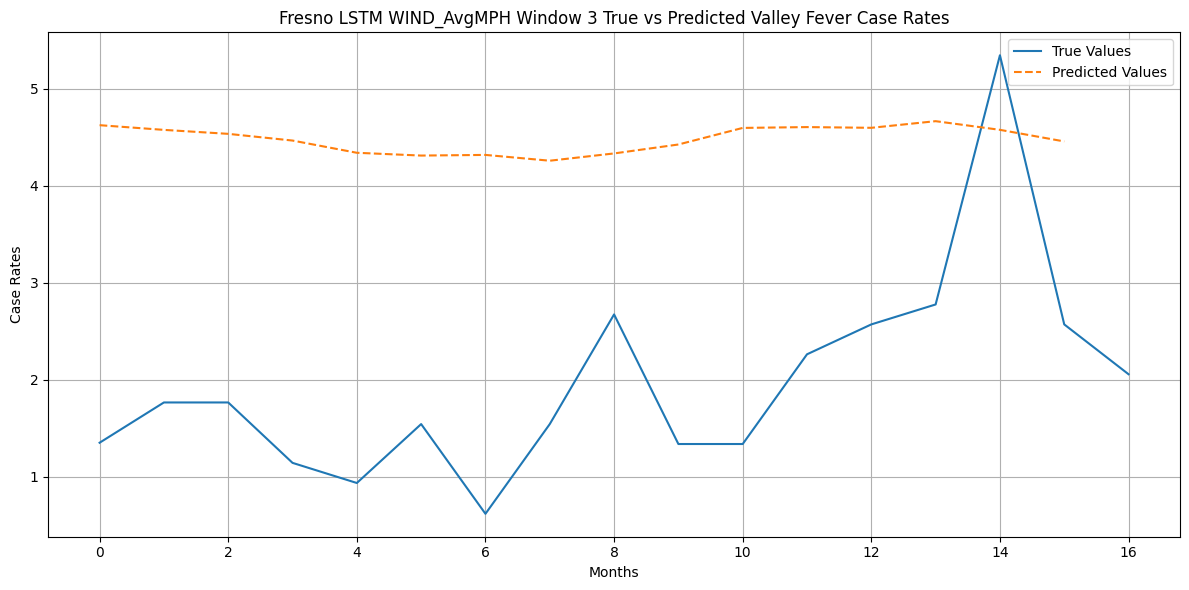

Epoch 1/300 - Training Loss 0.3273, Testing Loss 0.0877
Epoch 11/300 - Training Loss 0.2350, Testing Loss 0.1486
Epoch 21/300 - Training Loss 0.2277, Testing Loss 0.2567
Epoch 31/300 - Training Loss 0.2212, Testing Loss 0.2049
Epoch 41/300 - Training Loss 0.2221, Testing Loss 0.1881
Epoch 51/300 - Training Loss 0.2214, Testing Loss 0.2076
Epoch 61/300 - Training Loss 0.2216, Testing Loss 0.2105
Epoch 71/300 - Training Loss 0.2184, Testing Loss 0.2018
Epoch 81/300 - Training Loss 0.2204, Testing Loss 0.2045
Epoch 91/300 - Training Loss 0.2180, Testing Loss 0.2065
Epoch 101/300 - Training Loss 0.2184, Testing Loss 0.2038
Epoch 111/300 - Training Loss 0.2170, Testing Loss 0.2057
Epoch 121/300 - Training Loss 0.2164, Testing Loss 0.2006
Epoch 131/300 - Training Loss 0.2139, Testing Loss 0.2032
Epoch 141/300 - Training Loss 0.2159, Testing Loss 0.2043
Epoch 151/300 - Training Loss 0.2123, Testing Loss 0.2035
Epoch 161/300 - Training Loss 0.2142, Testing Loss 0.2028
Epoch 171/300 - Training 

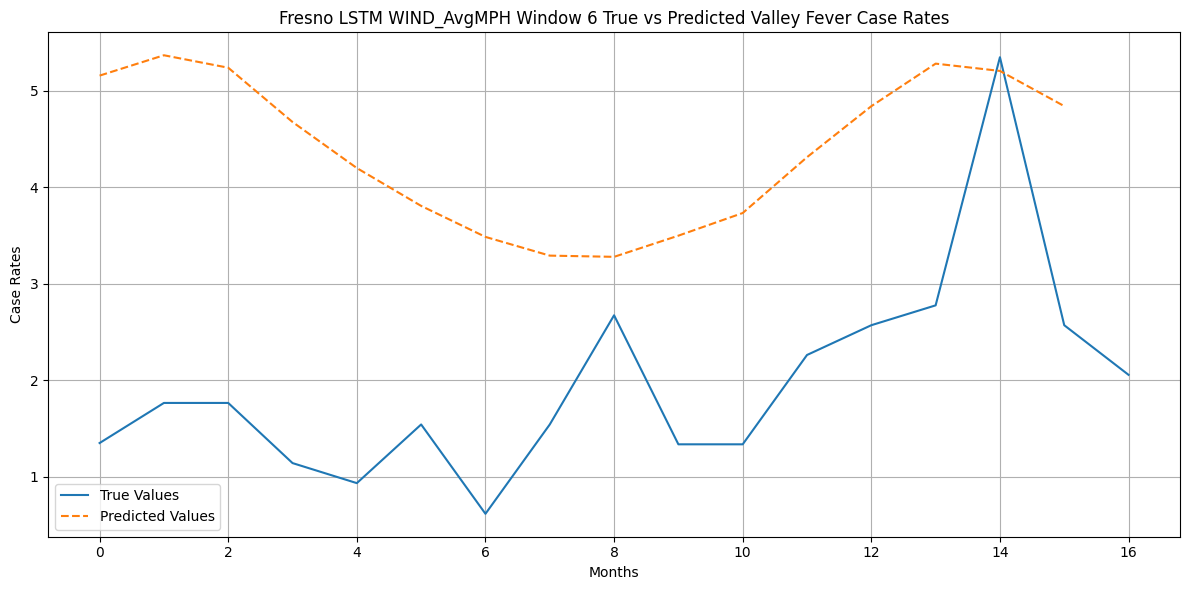

Epoch 1/300 - Training Loss 0.2658, Testing Loss 0.0980
Epoch 11/300 - Training Loss 0.2265, Testing Loss 0.2305
Epoch 21/300 - Training Loss 0.2250, Testing Loss 0.2013
Epoch 31/300 - Training Loss 0.2264, Testing Loss 0.1826
Epoch 41/300 - Training Loss 0.2260, Testing Loss 0.2070
Epoch 51/300 - Training Loss 0.2245, Testing Loss 0.1975
Epoch 61/300 - Training Loss 0.2245, Testing Loss 0.1963
Epoch 71/300 - Training Loss 0.2240, Testing Loss 0.1987
Epoch 81/300 - Training Loss 0.2239, Testing Loss 0.1963
Epoch 91/300 - Training Loss 0.2216, Testing Loss 0.1949
Epoch 101/300 - Training Loss 0.2195, Testing Loss 0.1935
Epoch 111/300 - Training Loss 0.2206, Testing Loss 0.1869
Epoch 121/300 - Training Loss 0.2158, Testing Loss 0.1977
Epoch 131/300 - Training Loss 0.2199, Testing Loss 0.1891
Epoch 141/300 - Training Loss 0.2174, Testing Loss 0.1853
Epoch 151/300 - Training Loss 0.2183, Testing Loss 0.1869
Epoch 161/300 - Training Loss 0.2173, Testing Loss 0.1869
Epoch 171/300 - Training 

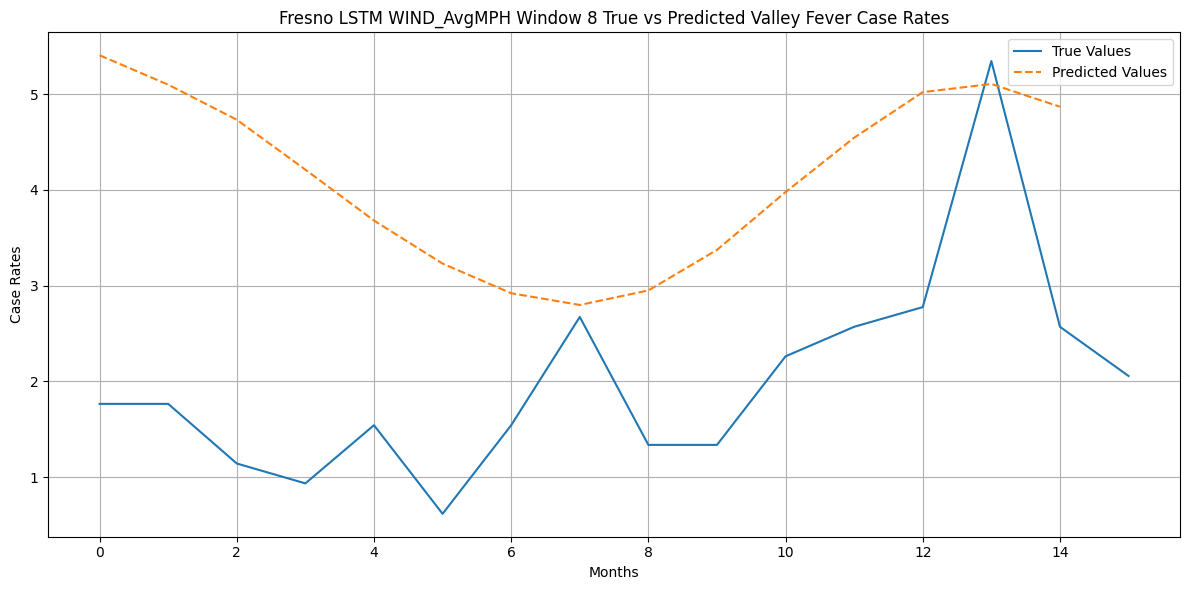

Epoch 1/300 - Training Loss 0.2339, Testing Loss 0.1791
Epoch 11/300 - Training Loss 0.2309, Testing Loss 0.1902
Epoch 21/300 - Training Loss 0.2306, Testing Loss 0.1983
Epoch 31/300 - Training Loss 0.2298, Testing Loss 0.1874
Epoch 41/300 - Training Loss 0.2297, Testing Loss 0.1909
Epoch 51/300 - Training Loss 0.2264, Testing Loss 0.1841
Epoch 61/300 - Training Loss 0.2245, Testing Loss 0.1737
Epoch 71/300 - Training Loss 0.2214, Testing Loss 0.1643
Epoch 81/300 - Training Loss 0.2217, Testing Loss 0.1617
Epoch 91/300 - Training Loss 0.2207, Testing Loss 0.1634
Epoch 101/300 - Training Loss 0.2232, Testing Loss 0.1669
Epoch 111/300 - Training Loss 0.2174, Testing Loss 0.1638
Epoch 121/300 - Training Loss 0.2176, Testing Loss 0.1631
Epoch 131/300 - Training Loss 0.2193, Testing Loss 0.1668
Epoch 141/300 - Training Loss 0.2160, Testing Loss 0.1945
Epoch 151/300 - Training Loss 0.2046, Testing Loss 0.3093
Epoch 161/300 - Training Loss 0.2074, Testing Loss 0.5569
Epoch 171/300 - Training 

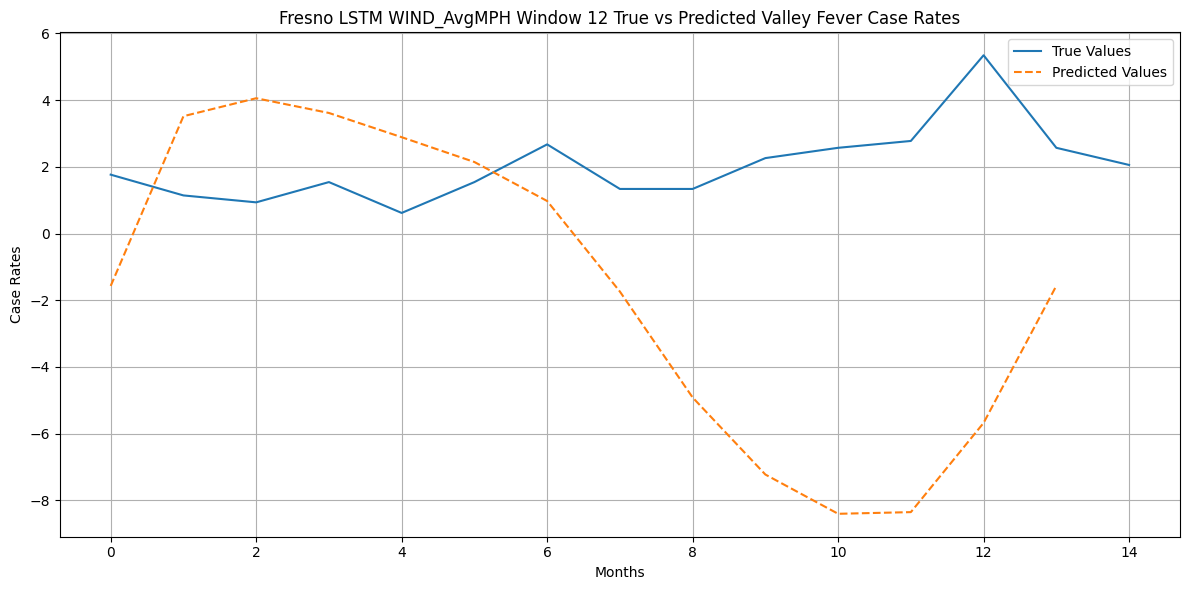

Epoch 1/300 - Training Loss 0.3005, Testing Loss 0.0784
Epoch 11/300 - Training Loss 0.2703, Testing Loss 0.0874
Epoch 21/300 - Training Loss 0.2434, Testing Loss 0.1195
Epoch 31/300 - Training Loss 0.2244, Testing Loss 0.1666
Epoch 41/300 - Training Loss 0.2165, Testing Loss 0.2131
Epoch 51/300 - Training Loss 0.2153, Testing Loss 0.2293
Epoch 61/300 - Training Loss 0.2182, Testing Loss 0.2168
Epoch 71/300 - Training Loss 0.2161, Testing Loss 0.2065
Epoch 81/300 - Training Loss 0.2160, Testing Loss 0.2074
Epoch 91/300 - Training Loss 0.2166, Testing Loss 0.2111
Epoch 101/300 - Training Loss 0.2144, Testing Loss 0.2121
Epoch 111/300 - Training Loss 0.2156, Testing Loss 0.2126
Epoch 121/300 - Training Loss 0.2161, Testing Loss 0.2124
Epoch 131/300 - Training Loss 0.2153, Testing Loss 0.2124
Epoch 141/300 - Training Loss 0.2142, Testing Loss 0.2126
Epoch 151/300 - Training Loss 0.2160, Testing Loss 0.2130
Epoch 161/300 - Training Loss 0.2174, Testing Loss 0.2127
Epoch 171/300 - Training 

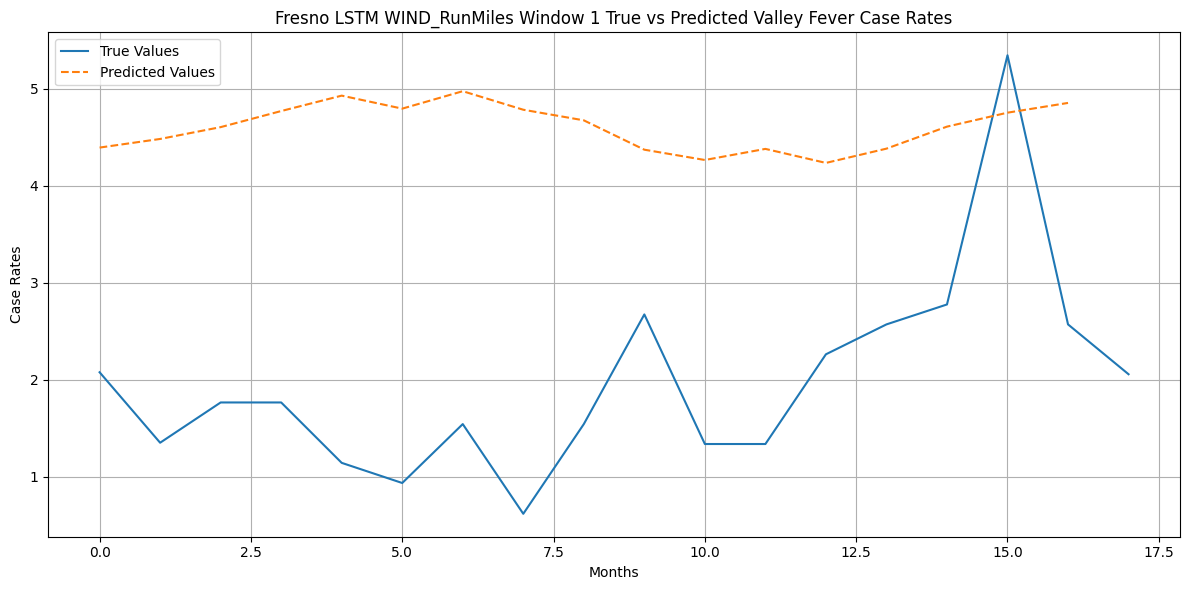

Epoch 1/300 - Training Loss 0.3282, Testing Loss 0.0905
Epoch 11/300 - Training Loss 0.2581, Testing Loss 0.1037
Epoch 21/300 - Training Loss 0.2192, Testing Loss 0.2115
Epoch 31/300 - Training Loss 0.2208, Testing Loss 0.2424
Epoch 41/300 - Training Loss 0.2194, Testing Loss 0.1972
Epoch 51/300 - Training Loss 0.2181, Testing Loss 0.1945
Epoch 61/300 - Training Loss 0.2200, Testing Loss 0.2121
Epoch 71/300 - Training Loss 0.2200, Testing Loss 0.2101
Epoch 81/300 - Training Loss 0.2183, Testing Loss 0.2040
Epoch 91/300 - Training Loss 0.2175, Testing Loss 0.2065
Epoch 101/300 - Training Loss 0.2158, Testing Loss 0.2077
Epoch 111/300 - Training Loss 0.2172, Testing Loss 0.2068
Epoch 121/300 - Training Loss 0.2192, Testing Loss 0.2069
Epoch 131/300 - Training Loss 0.2174, Testing Loss 0.2066
Epoch 141/300 - Training Loss 0.2193, Testing Loss 0.2074
Epoch 151/300 - Training Loss 0.2174, Testing Loss 0.2065
Epoch 161/300 - Training Loss 0.2185, Testing Loss 0.2066
Epoch 171/300 - Training 

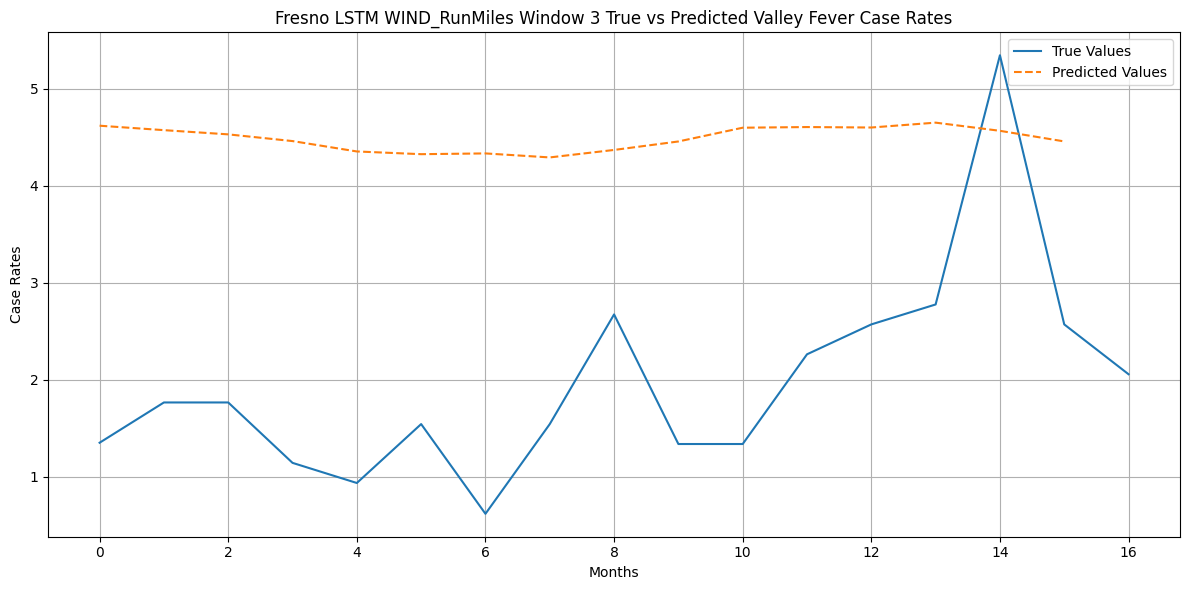

Epoch 1/300 - Training Loss 0.4340, Testing Loss 0.1897
Epoch 11/300 - Training Loss 0.3243, Testing Loss 0.0853
Epoch 21/300 - Training Loss 0.2216, Testing Loss 0.2360
Epoch 31/300 - Training Loss 0.2234, Testing Loss 0.2244
Epoch 41/300 - Training Loss 0.2241, Testing Loss 0.1717
Epoch 51/300 - Training Loss 0.2184, Testing Loss 0.2158
Epoch 61/300 - Training Loss 0.2160, Testing Loss 0.2096
Epoch 71/300 - Training Loss 0.2181, Testing Loss 0.1983
Epoch 81/300 - Training Loss 0.2193, Testing Loss 0.2090
Epoch 91/300 - Training Loss 0.2198, Testing Loss 0.2008
Epoch 101/300 - Training Loss 0.2143, Testing Loss 0.2070
Epoch 111/300 - Training Loss 0.2150, Testing Loss 0.2036
Epoch 121/300 - Training Loss 0.2174, Testing Loss 0.2066
Epoch 131/300 - Training Loss 0.2205, Testing Loss 0.1976
Epoch 141/300 - Training Loss 0.2133, Testing Loss 0.2067
Epoch 151/300 - Training Loss 0.2203, Testing Loss 0.2070
Epoch 161/300 - Training Loss 0.2159, Testing Loss 0.1997
Epoch 171/300 - Training 

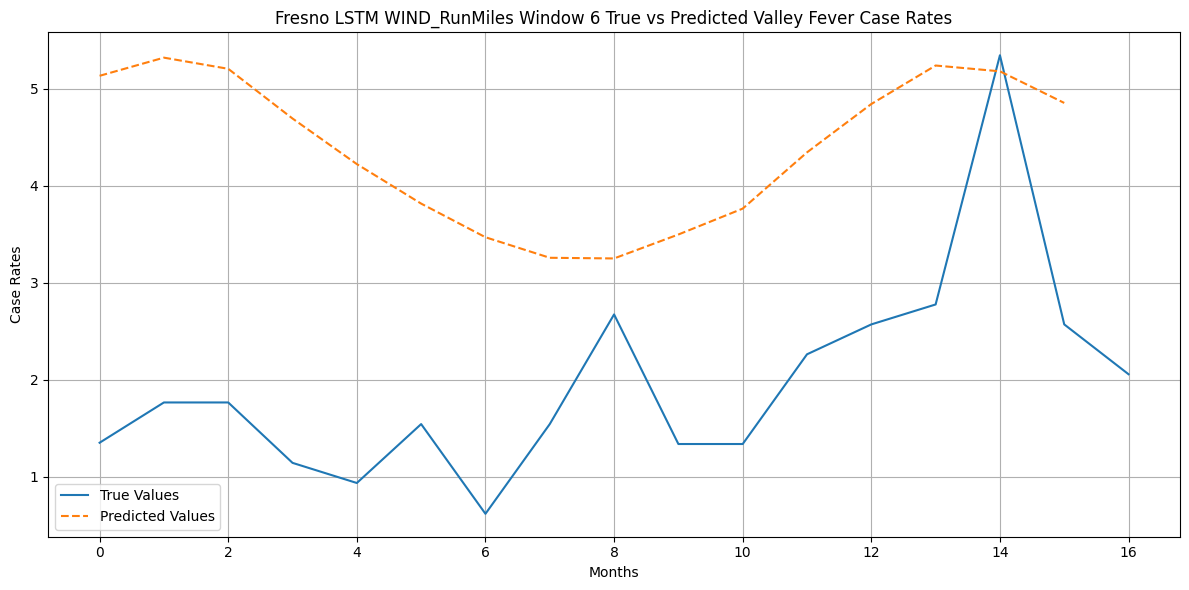

Epoch 1/300 - Training Loss 0.4426, Testing Loss 0.2065
Epoch 11/300 - Training Loss 0.3493, Testing Loss 0.1074
Epoch 21/300 - Training Loss 0.2364, Testing Loss 0.1604
Epoch 31/300 - Training Loss 0.2333, Testing Loss 0.2410
Epoch 41/300 - Training Loss 0.2243, Testing Loss 0.1623
Epoch 51/300 - Training Loss 0.2235, Testing Loss 0.2009
Epoch 61/300 - Training Loss 0.2240, Testing Loss 0.2038
Epoch 71/300 - Training Loss 0.2251, Testing Loss 0.1891
Epoch 81/300 - Training Loss 0.2243, Testing Loss 0.2005
Epoch 91/300 - Training Loss 0.2216, Testing Loss 0.1930
Epoch 101/300 - Training Loss 0.2235, Testing Loss 0.1991
Epoch 111/300 - Training Loss 0.2209, Testing Loss 0.1946
Epoch 121/300 - Training Loss 0.2200, Testing Loss 0.1965
Epoch 131/300 - Training Loss 0.2180, Testing Loss 0.1933
Epoch 141/300 - Training Loss 0.2175, Testing Loss 0.1964
Epoch 151/300 - Training Loss 0.2165, Testing Loss 0.1953
Epoch 161/300 - Training Loss 0.2165, Testing Loss 0.1887
Epoch 171/300 - Training 

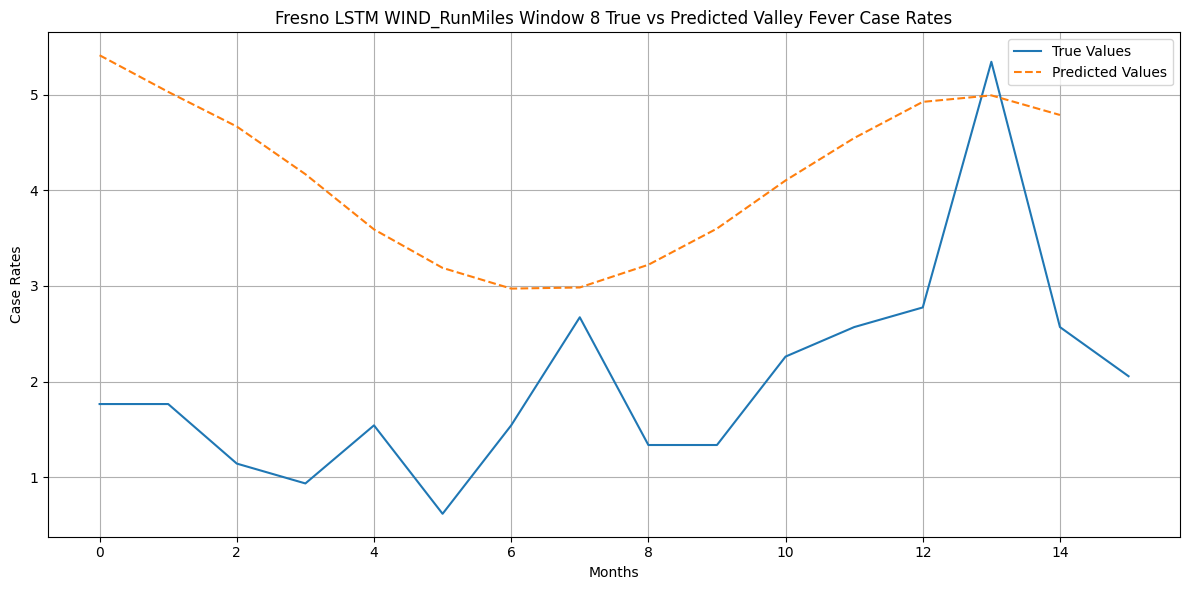

Epoch 1/300 - Training Loss 0.3716, Testing Loss 0.1320
Epoch 11/300 - Training Loss 0.2827, Testing Loss 0.0883
Epoch 21/300 - Training Loss 0.2342, Testing Loss 0.2517
Epoch 31/300 - Training Loss 0.2293, Testing Loss 0.1860
Epoch 41/300 - Training Loss 0.2316, Testing Loss 0.1719
Epoch 51/300 - Training Loss 0.2302, Testing Loss 0.2038
Epoch 61/300 - Training Loss 0.2305, Testing Loss 0.1916
Epoch 71/300 - Training Loss 0.2291, Testing Loss 0.1884
Epoch 81/300 - Training Loss 0.2288, Testing Loss 0.1940
Epoch 91/300 - Training Loss 0.2301, Testing Loss 0.1878
Epoch 101/300 - Training Loss 0.2283, Testing Loss 0.1890
Epoch 111/300 - Training Loss 0.2287, Testing Loss 0.1865
Epoch 121/300 - Training Loss 0.2255, Testing Loss 0.1866
Epoch 131/300 - Training Loss 0.2223, Testing Loss 0.1830
Epoch 141/300 - Training Loss 0.2241, Testing Loss 0.1777
Epoch 151/300 - Training Loss 0.2222, Testing Loss 0.1798
Epoch 161/300 - Training Loss 0.2206, Testing Loss 0.1762
Epoch 171/300 - Training 

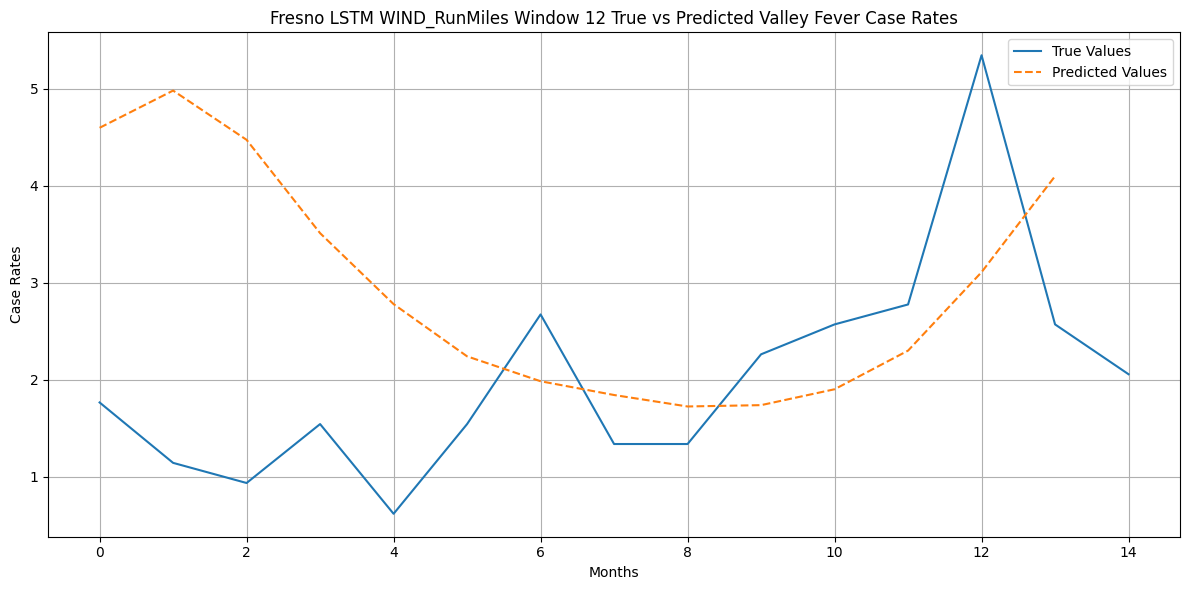

Epoch 1/300 - Training Loss 0.4641, Testing Loss 0.2238
Epoch 11/300 - Training Loss 0.4220, Testing Loss 0.1790
Epoch 21/300 - Training Loss 0.3765, Testing Loss 0.1321
Epoch 31/300 - Training Loss 0.3253, Testing Loss 0.0883
Epoch 41/300 - Training Loss 0.2677, Testing Loss 0.0907
Epoch 51/300 - Training Loss 0.2216, Testing Loss 0.1648
Epoch 61/300 - Training Loss 0.2231, Testing Loss 0.2364
Epoch 71/300 - Training Loss 0.2158, Testing Loss 0.2326
Epoch 81/300 - Training Loss 0.2146, Testing Loss 0.2056
Epoch 91/300 - Training Loss 0.2121, Testing Loss 0.1993
Epoch 101/300 - Training Loss 0.2190, Testing Loss 0.2073
Epoch 111/300 - Training Loss 0.2167, Testing Loss 0.2123
Epoch 121/300 - Training Loss 0.2178, Testing Loss 0.2107
Epoch 131/300 - Training Loss 0.2177, Testing Loss 0.2059
Epoch 141/300 - Training Loss 0.2141, Testing Loss 0.2057
Epoch 151/300 - Training Loss 0.2160, Testing Loss 0.2092
Epoch 161/300 - Training Loss 0.2155, Testing Loss 0.2096
Epoch 171/300 - Training 

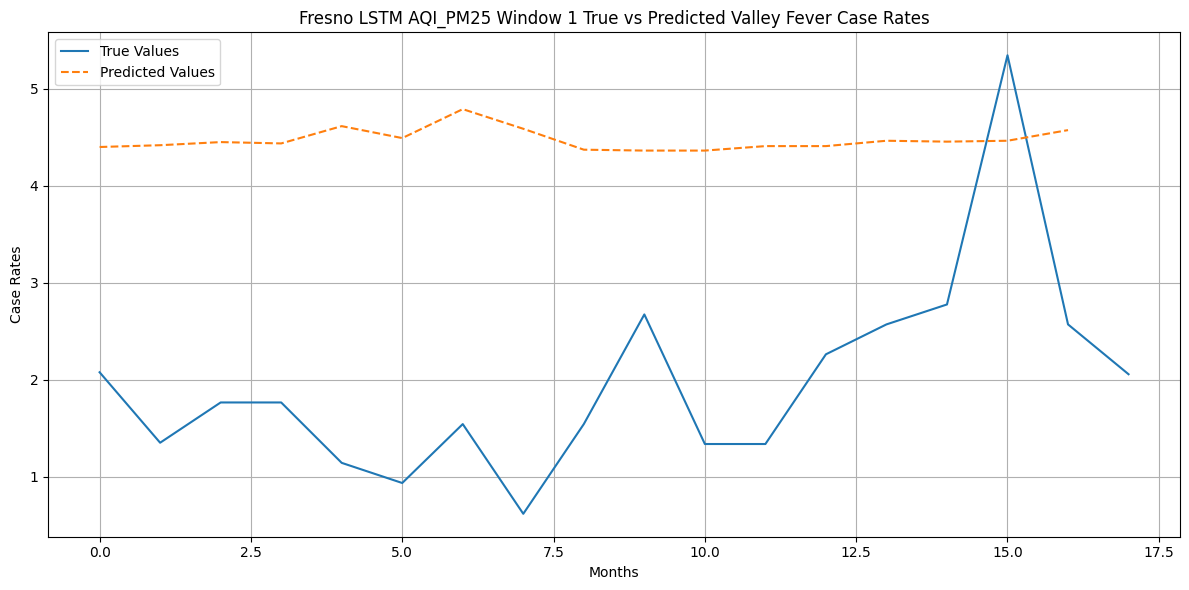

Epoch 1/300 - Training Loss 0.3630, Testing Loss 0.1176
Epoch 11/300 - Training Loss 0.2853, Testing Loss 0.0830
Epoch 21/300 - Training Loss 0.2296, Testing Loss 0.1547
Epoch 31/300 - Training Loss 0.2202, Testing Loss 0.2401
Epoch 41/300 - Training Loss 0.2209, Testing Loss 0.2251
Epoch 51/300 - Training Loss 0.2196, Testing Loss 0.1965
Epoch 61/300 - Training Loss 0.2187, Testing Loss 0.2000
Epoch 71/300 - Training Loss 0.2174, Testing Loss 0.2104
Epoch 81/300 - Training Loss 0.2173, Testing Loss 0.2093
Epoch 91/300 - Training Loss 0.2180, Testing Loss 0.2073
Epoch 101/300 - Training Loss 0.2200, Testing Loss 0.2076
Epoch 111/300 - Training Loss 0.2174, Testing Loss 0.2086
Epoch 121/300 - Training Loss 0.2172, Testing Loss 0.2083
Epoch 131/300 - Training Loss 0.2178, Testing Loss 0.2090
Epoch 141/300 - Training Loss 0.2174, Testing Loss 0.2084
Epoch 151/300 - Training Loss 0.2182, Testing Loss 0.2093
Epoch 161/300 - Training Loss 0.2191, Testing Loss 0.2091
Epoch 171/300 - Training 

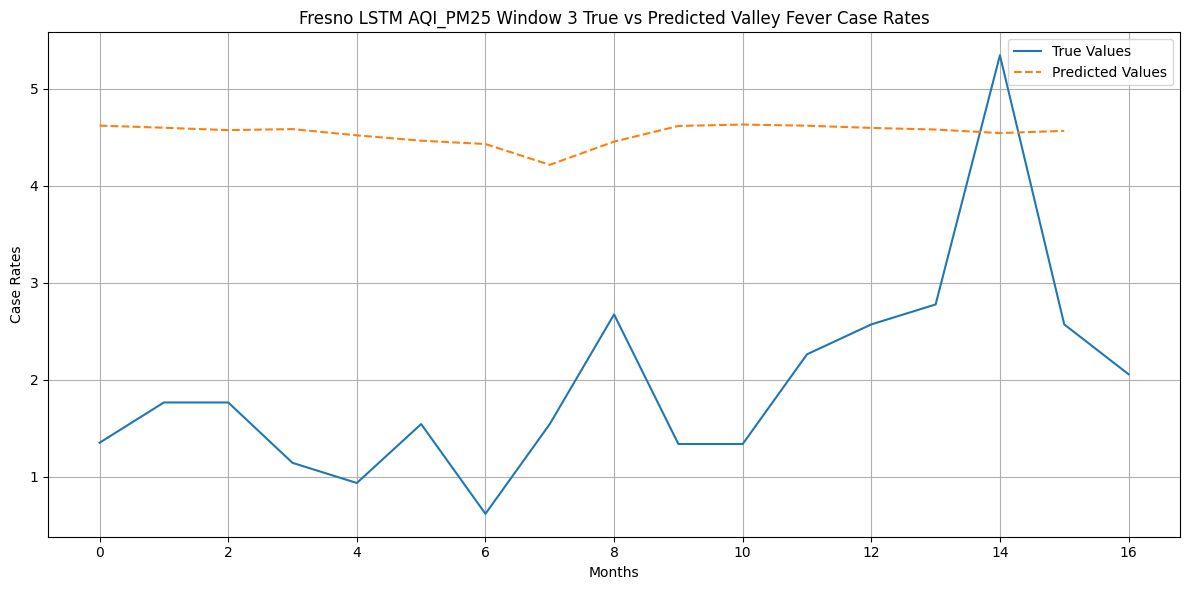

Epoch 1/300 - Training Loss 0.3734, Testing Loss 0.1268
Epoch 11/300 - Training Loss 0.2838, Testing Loss 0.0843
Epoch 21/300 - Training Loss 0.2245, Testing Loss 0.1880
Epoch 31/300 - Training Loss 0.2270, Testing Loss 0.2494
Epoch 41/300 - Training Loss 0.2209, Testing Loss 0.1953
Epoch 51/300 - Training Loss 0.2229, Testing Loss 0.1920
Epoch 61/300 - Training Loss 0.2205, Testing Loss 0.2120
Epoch 71/300 - Training Loss 0.2238, Testing Loss 0.2108
Epoch 81/300 - Training Loss 0.2215, Testing Loss 0.2034
Epoch 91/300 - Training Loss 0.2195, Testing Loss 0.2096
Epoch 101/300 - Training Loss 0.2189, Testing Loss 0.2108
Epoch 111/300 - Training Loss 0.2203, Testing Loss 0.2094
Epoch 121/300 - Training Loss 0.2173, Testing Loss 0.2169
Epoch 131/300 - Training Loss 0.2128, Testing Loss 0.2210
Epoch 141/300 - Training Loss 0.2118, Testing Loss 0.2372
Epoch 151/300 - Training Loss 0.2111, Testing Loss 0.2437
Epoch 161/300 - Training Loss 0.2142, Testing Loss 0.2385
Epoch 171/300 - Training 

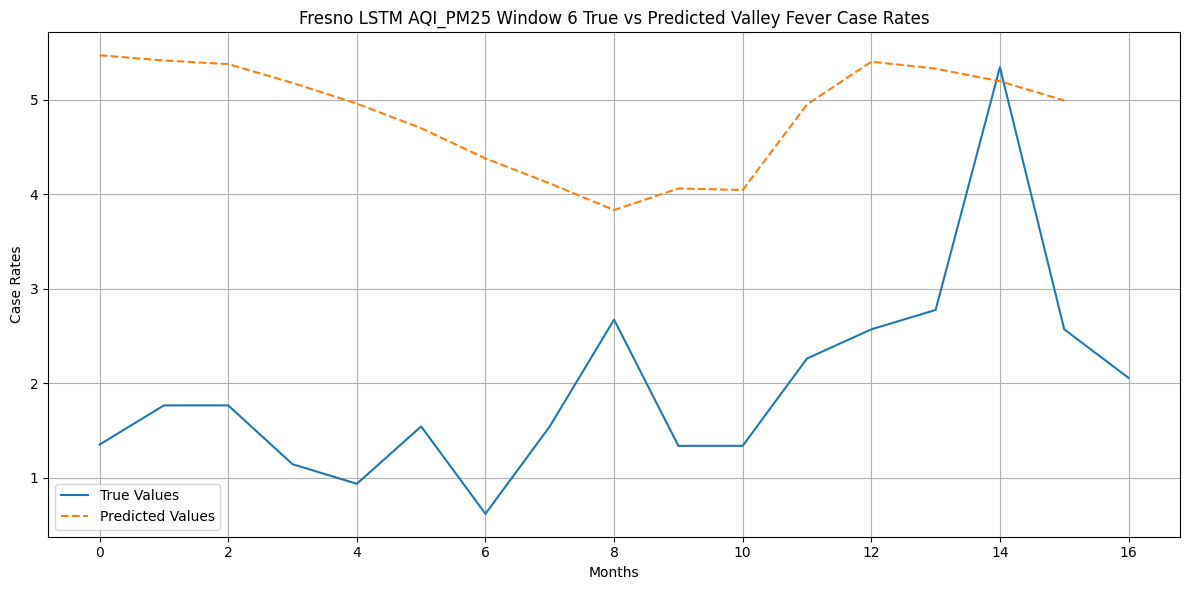

Epoch 1/300 - Training Loss 0.3130, Testing Loss 0.0848
Epoch 11/300 - Training Loss 0.2391, Testing Loss 0.1436
Epoch 21/300 - Training Loss 0.2279, Testing Loss 0.2448
Epoch 31/300 - Training Loss 0.2251, Testing Loss 0.1961
Epoch 41/300 - Training Loss 0.2248, Testing Loss 0.1829
Epoch 51/300 - Training Loss 0.2241, Testing Loss 0.2030
Epoch 61/300 - Training Loss 0.2248, Testing Loss 0.2043
Epoch 71/300 - Training Loss 0.2238, Testing Loss 0.1965
Epoch 81/300 - Training Loss 0.2252, Testing Loss 0.2037
Epoch 91/300 - Training Loss 0.2215, Testing Loss 0.2048
Epoch 101/300 - Training Loss 0.2201, Testing Loss 0.2115
Epoch 111/300 - Training Loss 0.2143, Testing Loss 0.2315
Epoch 121/300 - Training Loss 0.2141, Testing Loss 0.2451
Epoch 131/300 - Training Loss 0.2131, Testing Loss 0.2407
Epoch 141/300 - Training Loss 0.2128, Testing Loss 0.2416
Epoch 151/300 - Training Loss 0.2143, Testing Loss 0.2381
Epoch 161/300 - Training Loss 0.2122, Testing Loss 0.2373
Epoch 171/300 - Training 

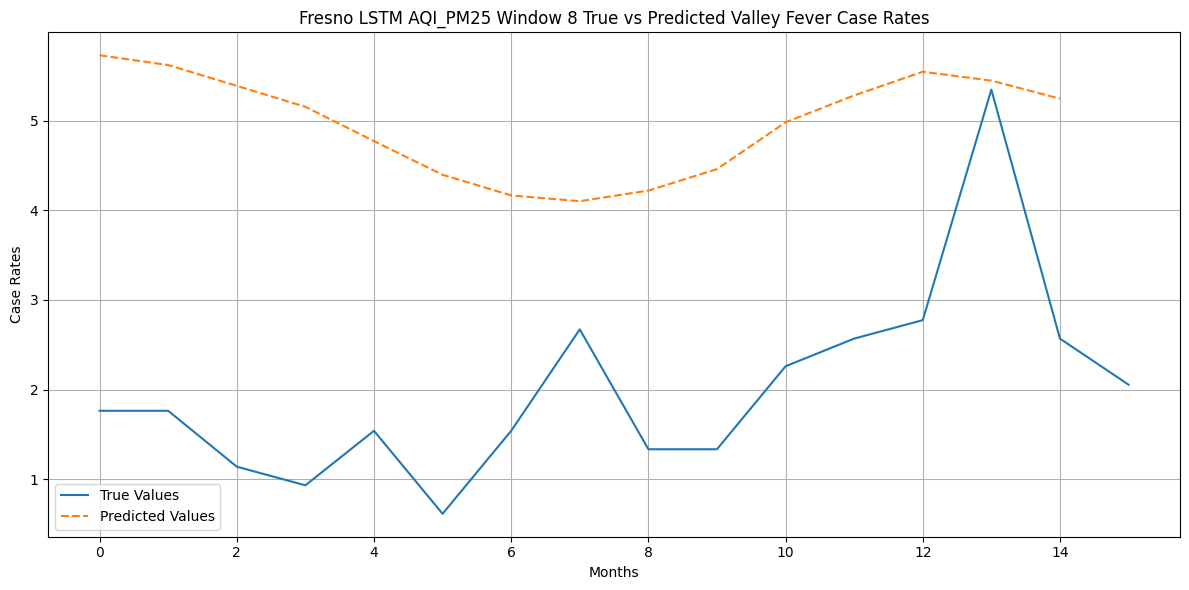

Epoch 1/300 - Training Loss 0.3961, Testing Loss 0.1537
Epoch 11/300 - Training Loss 0.2803, Testing Loss 0.0947
Epoch 21/300 - Training Loss 0.2424, Testing Loss 0.2698
Epoch 31/300 - Training Loss 0.2317, Testing Loss 0.1785
Epoch 41/300 - Training Loss 0.2328, Testing Loss 0.1787
Epoch 51/300 - Training Loss 0.2324, Testing Loss 0.2121
Epoch 61/300 - Training Loss 0.2326, Testing Loss 0.1929
Epoch 71/300 - Training Loss 0.2311, Testing Loss 0.1968
Epoch 81/300 - Training Loss 0.2343, Testing Loss 0.2007
Epoch 91/300 - Training Loss 0.2317, Testing Loss 0.1970
Epoch 101/300 - Training Loss 0.2316, Testing Loss 0.2011
Epoch 111/300 - Training Loss 0.2286, Testing Loss 0.1993
Epoch 121/300 - Training Loss 0.2302, Testing Loss 0.2003
Epoch 131/300 - Training Loss 0.2303, Testing Loss 0.2028
Epoch 141/300 - Training Loss 0.2284, Testing Loss 0.2066
Epoch 151/300 - Training Loss 0.2238, Testing Loss 0.2091
Epoch 161/300 - Training Loss 0.2212, Testing Loss 0.2137
Epoch 171/300 - Training 

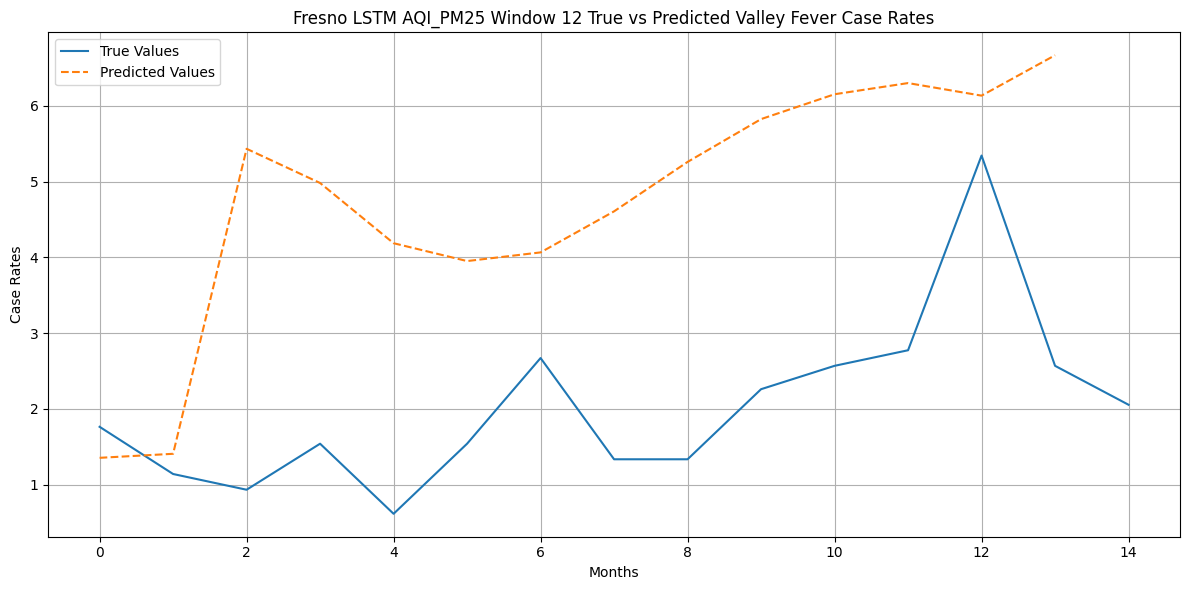

Epoch 1/300 - Training Loss 0.3872, Testing Loss 0.1434
Epoch 11/300 - Training Loss 0.3498, Testing Loss 0.1074
Epoch 21/300 - Training Loss 0.3133, Testing Loss 0.0817
Epoch 31/300 - Training Loss 0.2767, Testing Loss 0.0830
Epoch 41/300 - Training Loss 0.2416, Testing Loss 0.1223
Epoch 51/300 - Training Loss 0.2191, Testing Loss 0.1829
Epoch 61/300 - Training Loss 0.2152, Testing Loss 0.2301
Epoch 71/300 - Training Loss 0.2149, Testing Loss 0.2306
Epoch 81/300 - Training Loss 0.2136, Testing Loss 0.2128
Epoch 91/300 - Training Loss 0.2187, Testing Loss 0.2055
Epoch 101/300 - Training Loss 0.2180, Testing Loss 0.2084
Epoch 111/300 - Training Loss 0.2171, Testing Loss 0.2110
Epoch 121/300 - Training Loss 0.2179, Testing Loss 0.2123
Epoch 131/300 - Training Loss 0.2137, Testing Loss 0.2113
Epoch 141/300 - Training Loss 0.2155, Testing Loss 0.2102
Epoch 151/300 - Training Loss 0.2179, Testing Loss 0.2110
Epoch 161/300 - Training Loss 0.2157, Testing Loss 0.2111
Epoch 171/300 - Training 

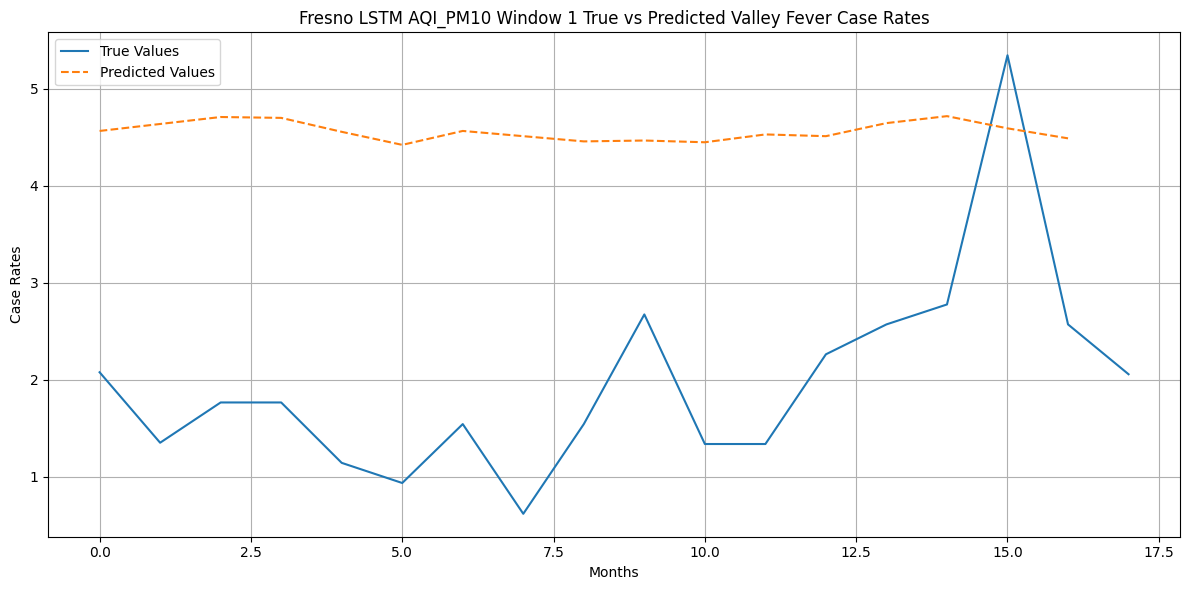

Epoch 1/300 - Training Loss 0.4906, Testing Loss 0.2500
Epoch 11/300 - Training Loss 0.4083, Testing Loss 0.1616
Epoch 21/300 - Training Loss 0.3174, Testing Loss 0.0826
Epoch 31/300 - Training Loss 0.2291, Testing Loss 0.1719
Epoch 41/300 - Training Loss 0.2299, Testing Loss 0.2759
Epoch 51/300 - Training Loss 0.2178, Testing Loss 0.2017
Epoch 61/300 - Training Loss 0.2191, Testing Loss 0.1903
Epoch 71/300 - Training Loss 0.2183, Testing Loss 0.2171
Epoch 81/300 - Training Loss 0.2197, Testing Loss 0.2156
Epoch 91/300 - Training Loss 0.2189, Testing Loss 0.2058
Epoch 101/300 - Training Loss 0.2175, Testing Loss 0.2105
Epoch 111/300 - Training Loss 0.2200, Testing Loss 0.2113
Epoch 121/300 - Training Loss 0.2198, Testing Loss 0.2088
Epoch 131/300 - Training Loss 0.2195, Testing Loss 0.2087
Epoch 141/300 - Training Loss 0.2183, Testing Loss 0.2094
Epoch 151/300 - Training Loss 0.2197, Testing Loss 0.2086
Epoch 161/300 - Training Loss 0.2170, Testing Loss 0.2089
Epoch 171/300 - Training 

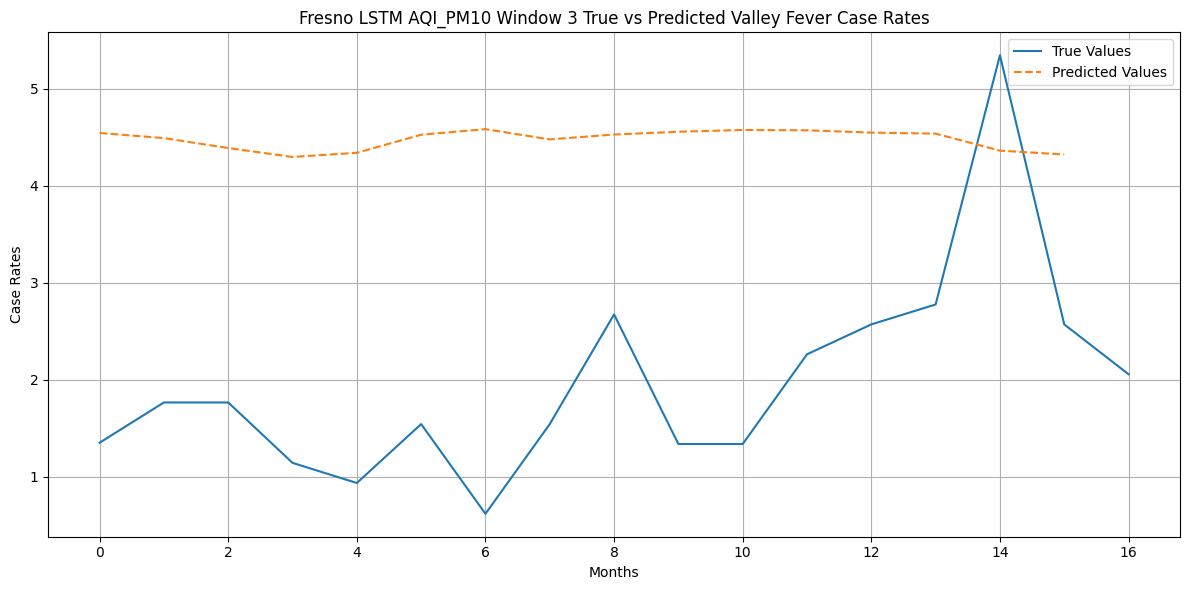

Epoch 1/300 - Training Loss 0.2339, Testing Loss 0.1550
Epoch 11/300 - Training Loss 0.2232, Testing Loss 0.2318
Epoch 21/300 - Training Loss 0.2217, Testing Loss 0.1947
Epoch 31/300 - Training Loss 0.2217, Testing Loss 0.2066
Epoch 41/300 - Training Loss 0.2204, Testing Loss 0.2070
Epoch 51/300 - Training Loss 0.2197, Testing Loss 0.2027
Epoch 61/300 - Training Loss 0.2175, Testing Loss 0.2027
Epoch 71/300 - Training Loss 0.2123, Testing Loss 0.2059
Epoch 81/300 - Training Loss 0.2055, Testing Loss 0.1980
Epoch 91/300 - Training Loss 0.2064, Testing Loss 0.2128
Epoch 101/300 - Training Loss 0.2039, Testing Loss 0.2116
Epoch 111/300 - Training Loss 0.2056, Testing Loss 0.2093
Epoch 121/300 - Training Loss 0.2070, Testing Loss 0.2160
Epoch 131/300 - Training Loss 0.2030, Testing Loss 0.2221
Epoch 141/300 - Training Loss 0.2064, Testing Loss 0.2172
Epoch 151/300 - Training Loss 0.2033, Testing Loss 0.2223
Epoch 161/300 - Training Loss 0.2034, Testing Loss 0.2132
Epoch 171/300 - Training 

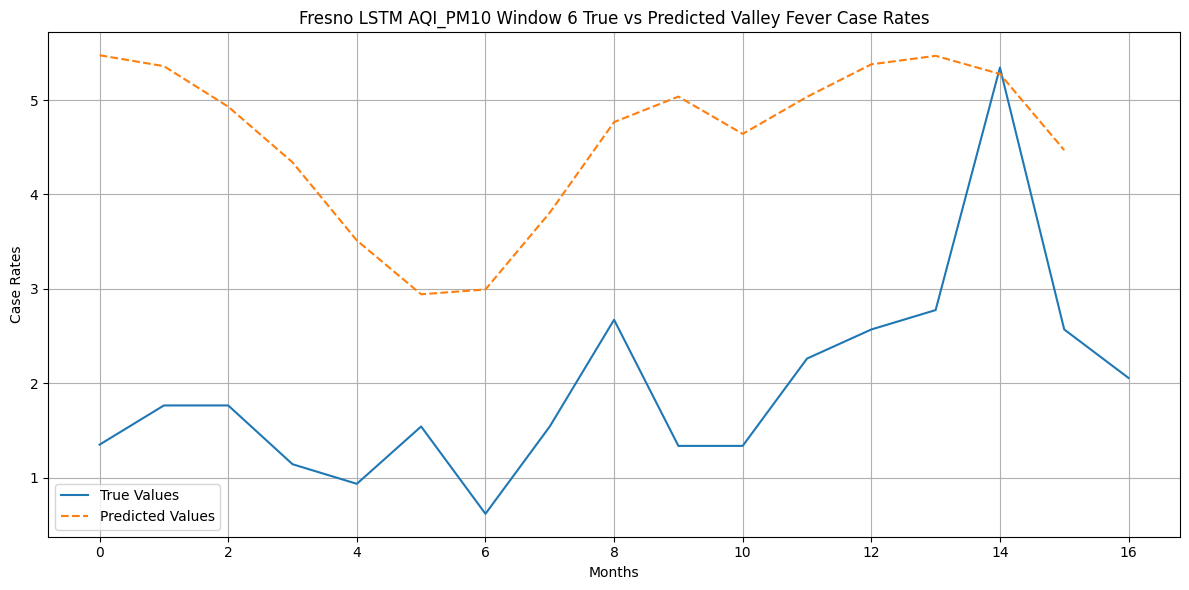

Epoch 1/300 - Training Loss 0.2742, Testing Loss 0.0898
Epoch 11/300 - Training Loss 0.2275, Testing Loss 0.1850
Epoch 21/300 - Training Loss 0.2271, Testing Loss 0.2293
Epoch 31/300 - Training Loss 0.2250, Testing Loss 0.1870
Epoch 41/300 - Training Loss 0.2250, Testing Loss 0.1917
Epoch 51/300 - Training Loss 0.2239, Testing Loss 0.2053
Epoch 61/300 - Training Loss 0.2234, Testing Loss 0.1963
Epoch 71/300 - Training Loss 0.2208, Testing Loss 0.1980
Epoch 81/300 - Training Loss 0.2138, Testing Loss 0.1938
Epoch 91/300 - Training Loss 0.1992, Testing Loss 0.1876
Epoch 101/300 - Training Loss 0.2008, Testing Loss 0.1817
Epoch 111/300 - Training Loss 0.1989, Testing Loss 0.1929
Epoch 121/300 - Training Loss 0.1979, Testing Loss 0.1891
Epoch 131/300 - Training Loss 0.1983, Testing Loss 0.1969
Epoch 141/300 - Training Loss 0.1982, Testing Loss 0.1899
Epoch 151/300 - Training Loss 0.1993, Testing Loss 0.1924
Epoch 161/300 - Training Loss 0.1981, Testing Loss 0.1872
Epoch 171/300 - Training 

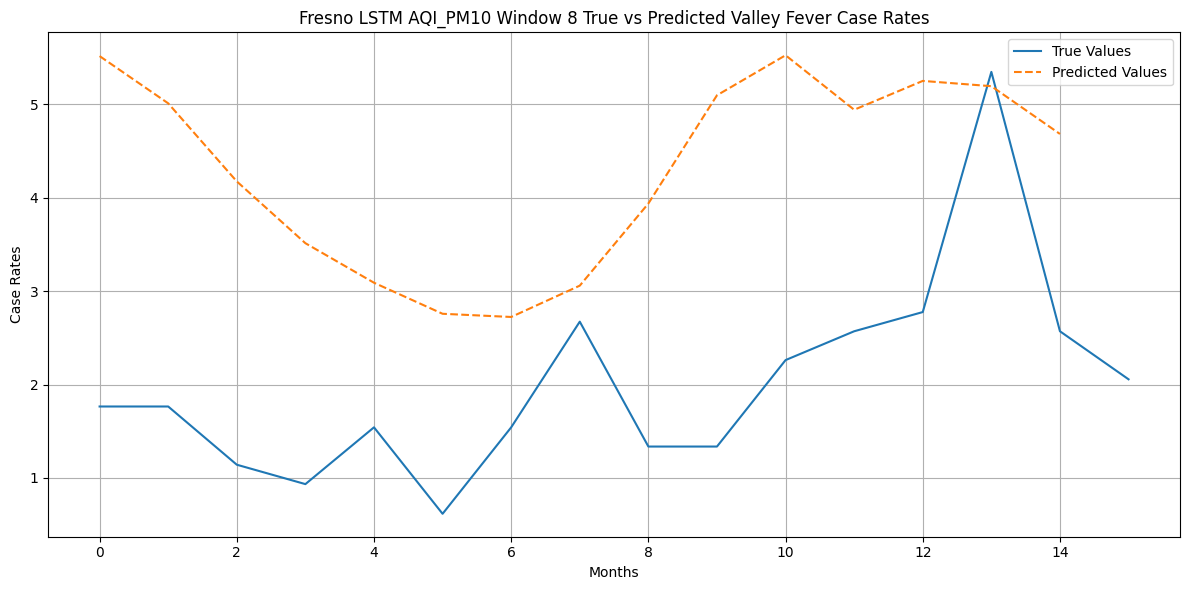

Epoch 1/300 - Training Loss 0.3397, Testing Loss 0.1011
Epoch 11/300 - Training Loss 0.2421, Testing Loss 0.1516
Epoch 21/300 - Training Loss 0.2389, Testing Loss 0.2390
Epoch 31/300 - Training Loss 0.2336, Testing Loss 0.1716
Epoch 41/300 - Training Loss 0.2308, Testing Loss 0.1934
Epoch 51/300 - Training Loss 0.2291, Testing Loss 0.2046
Epoch 61/300 - Training Loss 0.2297, Testing Loss 0.1900
Epoch 71/300 - Training Loss 0.2291, Testing Loss 0.1987
Epoch 81/300 - Training Loss 0.2209, Testing Loss 0.1906
Epoch 91/300 - Training Loss 0.2028, Testing Loss 0.1762
Epoch 101/300 - Training Loss 0.1862, Testing Loss 0.0931
Epoch 111/300 - Training Loss 0.1806, Testing Loss 0.1372
Epoch 121/300 - Training Loss 0.1798, Testing Loss 0.1227
Epoch 131/300 - Training Loss 0.1776, Testing Loss 0.1173
Epoch 141/300 - Training Loss 0.1770, Testing Loss 0.1244
Epoch 151/300 - Training Loss 0.1784, Testing Loss 0.1238
Epoch 161/300 - Training Loss 0.1761, Testing Loss 0.1209
Epoch 171/300 - Training 

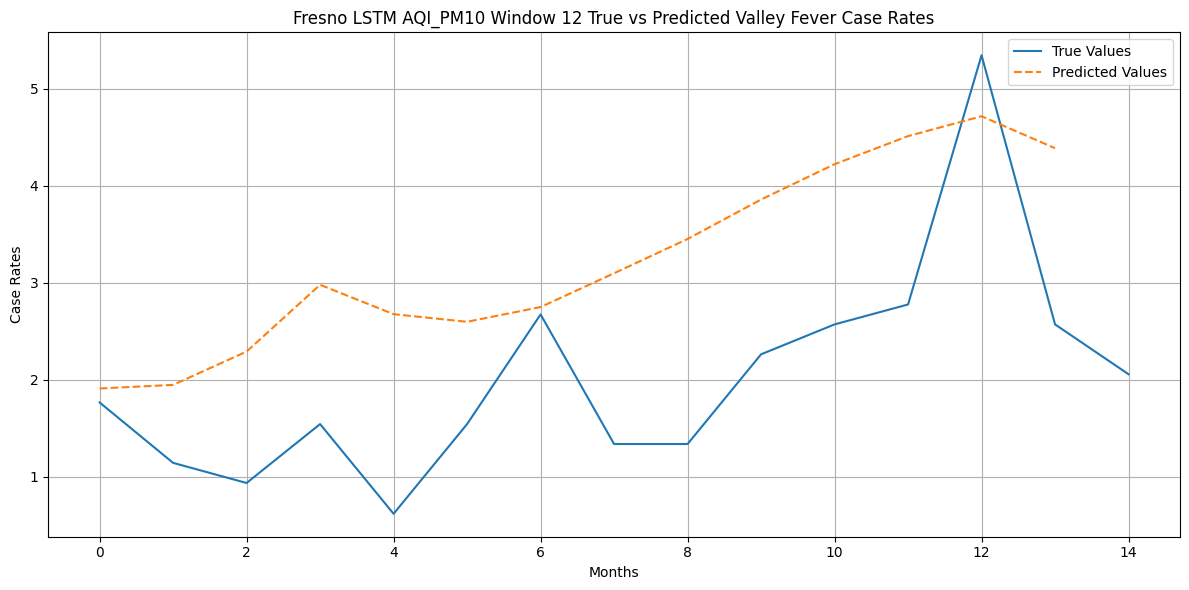

Epoch 1/300 - Training Loss 0.4496, Testing Loss 0.2081
Epoch 11/300 - Training Loss 0.4084, Testing Loss 0.1647
Epoch 21/300 - Training Loss 0.3673, Testing Loss 0.1238
Epoch 31/300 - Training Loss 0.3252, Testing Loss 0.0884
Epoch 41/300 - Training Loss 0.2812, Testing Loss 0.0817
Epoch 51/300 - Training Loss 0.2390, Testing Loss 0.1285
Epoch 61/300 - Training Loss 0.2155, Testing Loss 0.1990
Epoch 71/300 - Training Loss 0.2203, Testing Loss 0.2373
Epoch 81/300 - Training Loss 0.2171, Testing Loss 0.2252
Epoch 91/300 - Training Loss 0.2171, Testing Loss 0.2070
Epoch 101/300 - Training Loss 0.2199, Testing Loss 0.2032
Epoch 111/300 - Training Loss 0.2181, Testing Loss 0.2078
Epoch 121/300 - Training Loss 0.2166, Testing Loss 0.2114
Epoch 131/300 - Training Loss 0.2168, Testing Loss 0.2116
Epoch 141/300 - Training Loss 0.2183, Testing Loss 0.2105
Epoch 151/300 - Training Loss 0.2146, Testing Loss 0.2102
Epoch 161/300 - Training Loss 0.2170, Testing Loss 0.2122
Epoch 171/300 - Training 

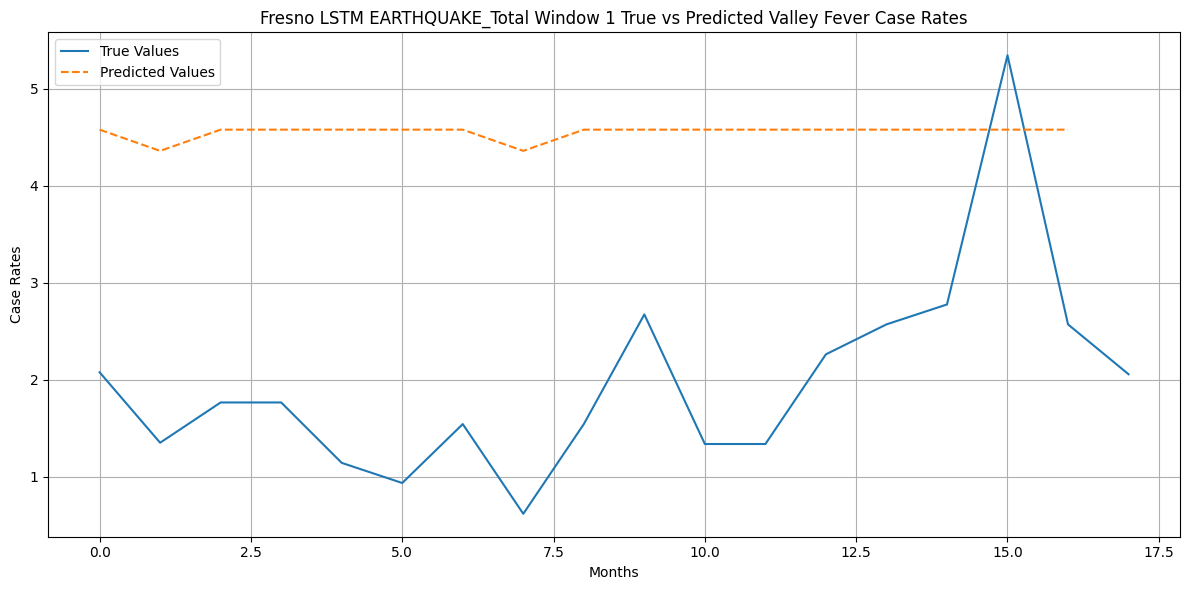

Epoch 1/300 - Training Loss 0.4792, Testing Loss 0.2377
Epoch 11/300 - Training Loss 0.3897, Testing Loss 0.1431
Epoch 21/300 - Training Loss 0.2948, Testing Loss 0.0809
Epoch 31/300 - Training Loss 0.2168, Testing Loss 0.1974
Epoch 41/300 - Training Loss 0.2290, Testing Loss 0.2640
Epoch 51/300 - Training Loss 0.2217, Testing Loss 0.1977
Epoch 61/300 - Training Loss 0.2198, Testing Loss 0.1893
Epoch 71/300 - Training Loss 0.2169, Testing Loss 0.2133
Epoch 81/300 - Training Loss 0.2191, Testing Loss 0.2143
Epoch 91/300 - Training Loss 0.2212, Testing Loss 0.2063
Epoch 101/300 - Training Loss 0.2155, Testing Loss 0.2085
Epoch 111/300 - Training Loss 0.2185, Testing Loss 0.2100
Epoch 121/300 - Training Loss 0.2175, Testing Loss 0.2077
Epoch 131/300 - Training Loss 0.2173, Testing Loss 0.2095
Epoch 141/300 - Training Loss 0.2179, Testing Loss 0.2108
Epoch 151/300 - Training Loss 0.2174, Testing Loss 0.2071
Epoch 161/300 - Training Loss 0.2198, Testing Loss 0.2080
Epoch 171/300 - Training 

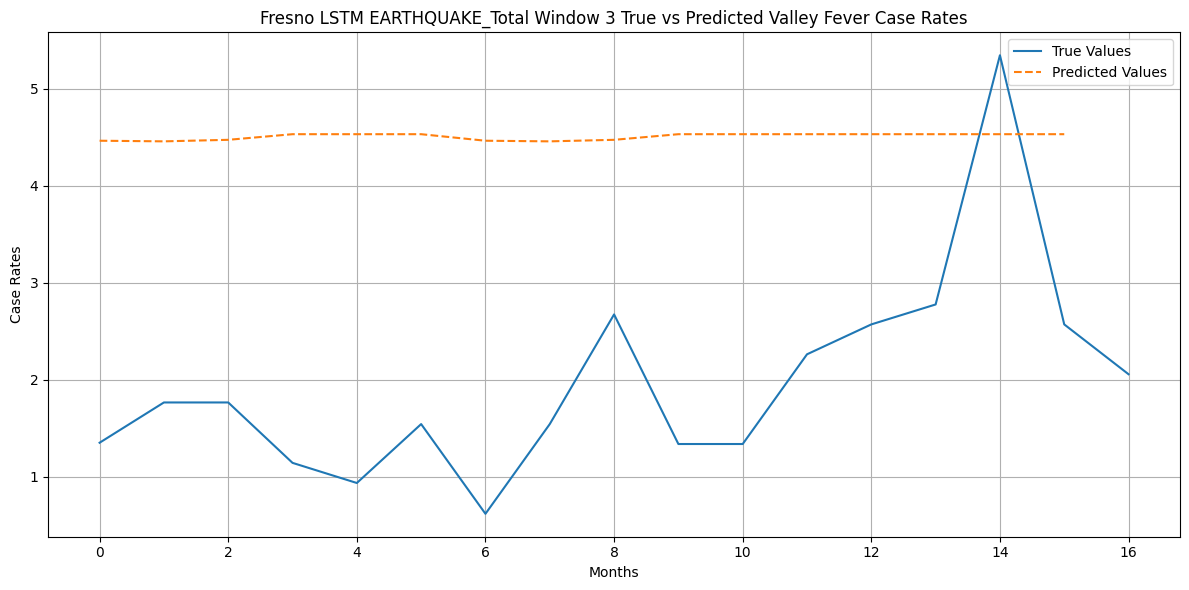

Epoch 1/300 - Training Loss 0.4812, Testing Loss 0.2394
Epoch 11/300 - Training Loss 0.3717, Testing Loss 0.1241
Epoch 21/300 - Training Loss 0.2546, Testing Loss 0.1193
Epoch 31/300 - Training Loss 0.2377, Testing Loss 0.2812
Epoch 41/300 - Training Loss 0.2218, Testing Loss 0.1918
Epoch 51/300 - Training Loss 0.2238, Testing Loss 0.1833
Epoch 61/300 - Training Loss 0.2213, Testing Loss 0.2166
Epoch 71/300 - Training Loss 0.2243, Testing Loss 0.2094
Epoch 81/300 - Training Loss 0.2212, Testing Loss 0.2003
Epoch 91/300 - Training Loss 0.2243, Testing Loss 0.2079
Epoch 101/300 - Training Loss 0.2226, Testing Loss 0.2068
Epoch 111/300 - Training Loss 0.2219, Testing Loss 0.2049
Epoch 121/300 - Training Loss 0.2253, Testing Loss 0.2063
Epoch 131/300 - Training Loss 0.2220, Testing Loss 0.2069
Epoch 141/300 - Training Loss 0.2209, Testing Loss 0.2075
Epoch 151/300 - Training Loss 0.2230, Testing Loss 0.2076
Epoch 161/300 - Training Loss 0.2207, Testing Loss 0.2080
Epoch 171/300 - Training 

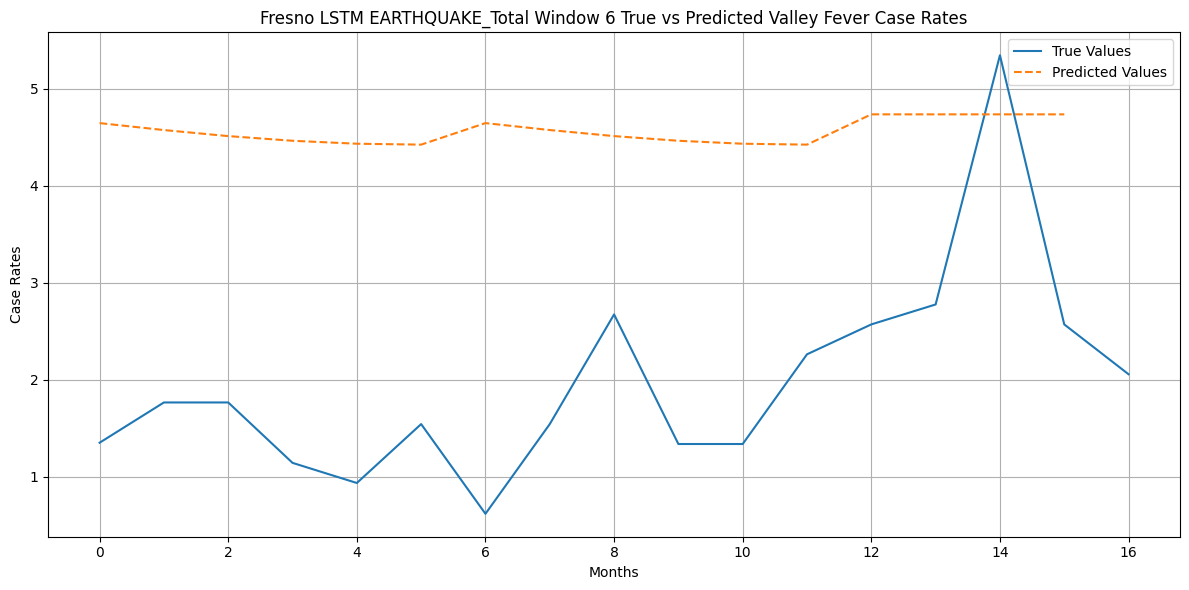

Epoch 1/300 - Training Loss 0.3134, Testing Loss 0.0844
Epoch 11/300 - Training Loss 0.2324, Testing Loss 0.1655
Epoch 21/300 - Training Loss 0.2300, Testing Loss 0.2437
Epoch 31/300 - Training Loss 0.2239, Testing Loss 0.1889
Epoch 41/300 - Training Loss 0.2256, Testing Loss 0.1858
Epoch 51/300 - Training Loss 0.2250, Testing Loss 0.2060
Epoch 61/300 - Training Loss 0.2262, Testing Loss 0.2017
Epoch 71/300 - Training Loss 0.2250, Testing Loss 0.1965
Epoch 81/300 - Training Loss 0.2252, Testing Loss 0.2004
Epoch 91/300 - Training Loss 0.2243, Testing Loss 0.2004
Epoch 101/300 - Training Loss 0.2254, Testing Loss 0.1993
Epoch 111/300 - Training Loss 0.2254, Testing Loss 0.2008
Epoch 121/300 - Training Loss 0.2256, Testing Loss 0.2000
Epoch 131/300 - Training Loss 0.2254, Testing Loss 0.2017
Epoch 141/300 - Training Loss 0.2247, Testing Loss 0.2015
Epoch 151/300 - Training Loss 0.2252, Testing Loss 0.2035
Epoch 161/300 - Training Loss 0.2235, Testing Loss 0.2043
Epoch 171/300 - Training 

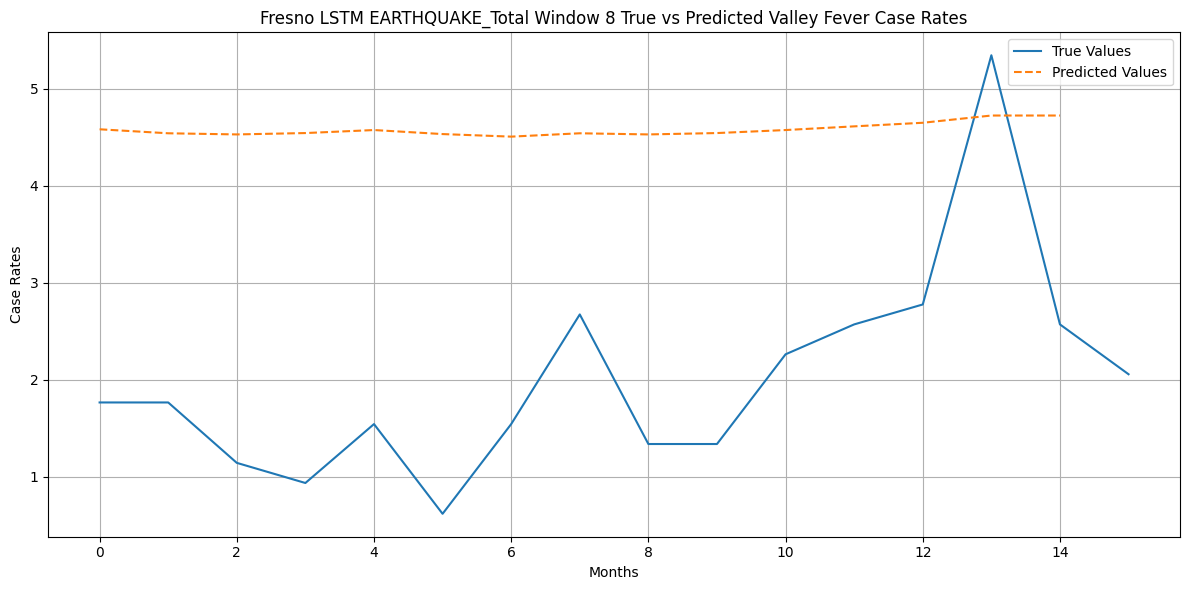

Epoch 1/300 - Training Loss 0.2973, Testing Loss 0.0845
Epoch 11/300 - Training Loss 0.2395, Testing Loss 0.1569
Epoch 21/300 - Training Loss 0.2361, Testing Loss 0.2367
Epoch 31/300 - Training Loss 0.2324, Testing Loss 0.1918
Epoch 41/300 - Training Loss 0.2324, Testing Loss 0.1842
Epoch 51/300 - Training Loss 0.2315, Testing Loss 0.1997
Epoch 61/300 - Training Loss 0.2315, Testing Loss 0.2009
Epoch 71/300 - Training Loss 0.2315, Testing Loss 0.1953
Epoch 81/300 - Training Loss 0.2316, Testing Loss 0.1973
Epoch 91/300 - Training Loss 0.2312, Testing Loss 0.1983
Epoch 101/300 - Training Loss 0.2322, Testing Loss 0.1971
Epoch 111/300 - Training Loss 0.2323, Testing Loss 0.1974
Epoch 121/300 - Training Loss 0.2317, Testing Loss 0.1977
Epoch 131/300 - Training Loss 0.2315, Testing Loss 0.1982
Epoch 141/300 - Training Loss 0.2311, Testing Loss 0.1979
Epoch 151/300 - Training Loss 0.2315, Testing Loss 0.1986
Epoch 161/300 - Training Loss 0.2308, Testing Loss 0.1978
Epoch 171/300 - Training 

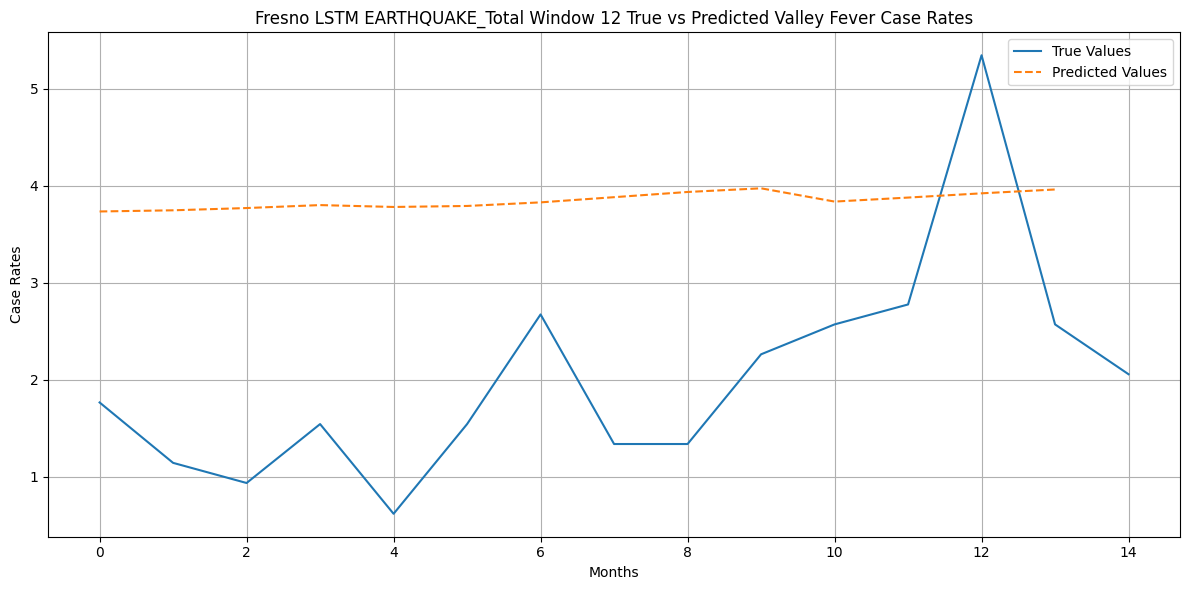

Epoch 1/300 - Training Loss 0.4384, Testing Loss 0.1961
Epoch 11/300 - Training Loss 0.3979, Testing Loss 0.1540
Epoch 21/300 - Training Loss 0.3573, Testing Loss 0.1137
Epoch 31/300 - Training Loss 0.3143, Testing Loss 0.0821
Epoch 41/300 - Training Loss 0.2697, Testing Loss 0.0903
Epoch 51/300 - Training Loss 0.2314, Testing Loss 0.1500
Epoch 61/300 - Training Loss 0.2161, Testing Loss 0.2167
Epoch 71/300 - Training Loss 0.2222, Testing Loss 0.2343
Epoch 81/300 - Training Loss 0.2169, Testing Loss 0.2140
Epoch 91/300 - Training Loss 0.2194, Testing Loss 0.2011
Epoch 101/300 - Training Loss 0.2172, Testing Loss 0.2030
Epoch 111/300 - Training Loss 0.2203, Testing Loss 0.2097
Epoch 121/300 - Training Loss 0.2189, Testing Loss 0.2116
Epoch 131/300 - Training Loss 0.2151, Testing Loss 0.2099
Epoch 141/300 - Training Loss 0.2170, Testing Loss 0.2100
Epoch 151/300 - Training Loss 0.2177, Testing Loss 0.2114
Epoch 161/300 - Training Loss 0.2150, Testing Loss 0.2109
Epoch 171/300 - Training 

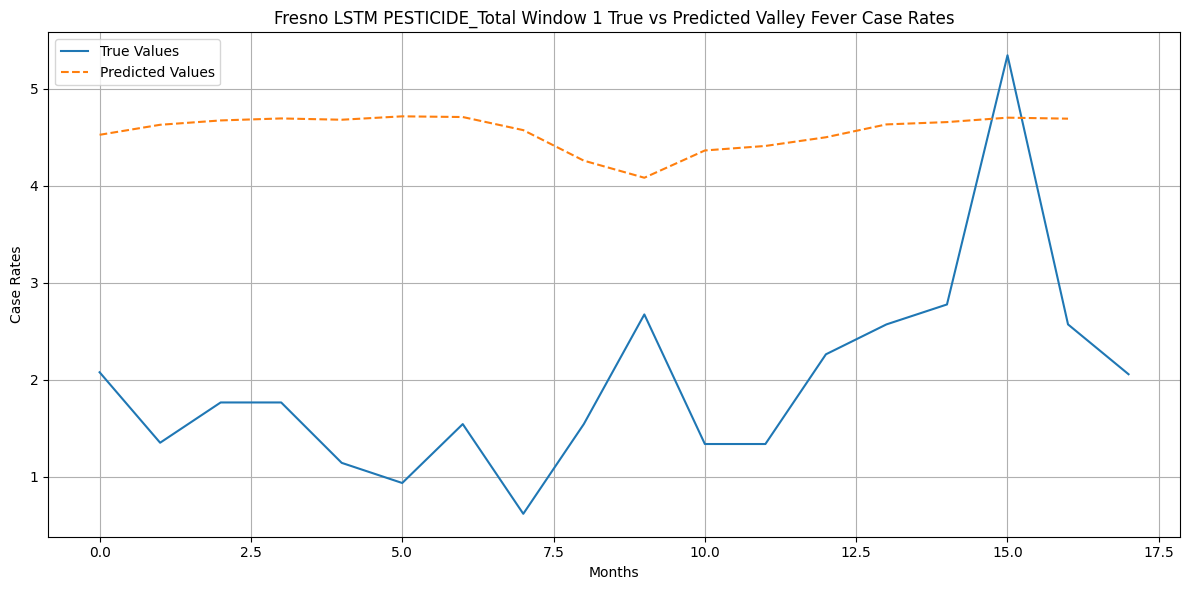

Epoch 1/300 - Training Loss 0.2524, Testing Loss 0.1101
Epoch 11/300 - Training Loss 0.2210, Testing Loss 0.1845
Epoch 21/300 - Training Loss 0.2216, Testing Loss 0.2348
Epoch 31/300 - Training Loss 0.2185, Testing Loss 0.2136
Epoch 41/300 - Training Loss 0.2179, Testing Loss 0.1993
Epoch 51/300 - Training Loss 0.2177, Testing Loss 0.2064
Epoch 61/300 - Training Loss 0.2181, Testing Loss 0.2127
Epoch 71/300 - Training Loss 0.2180, Testing Loss 0.2099
Epoch 81/300 - Training Loss 0.2177, Testing Loss 0.2086
Epoch 91/300 - Training Loss 0.2183, Testing Loss 0.2106
Epoch 101/300 - Training Loss 0.2172, Testing Loss 0.2106
Epoch 111/300 - Training Loss 0.2170, Testing Loss 0.2109
Epoch 121/300 - Training Loss 0.2175, Testing Loss 0.2104
Epoch 131/300 - Training Loss 0.2165, Testing Loss 0.2109
Epoch 141/300 - Training Loss 0.2170, Testing Loss 0.2132
Epoch 151/300 - Training Loss 0.2180, Testing Loss 0.2121
Epoch 161/300 - Training Loss 0.2167, Testing Loss 0.2122
Epoch 171/300 - Training 

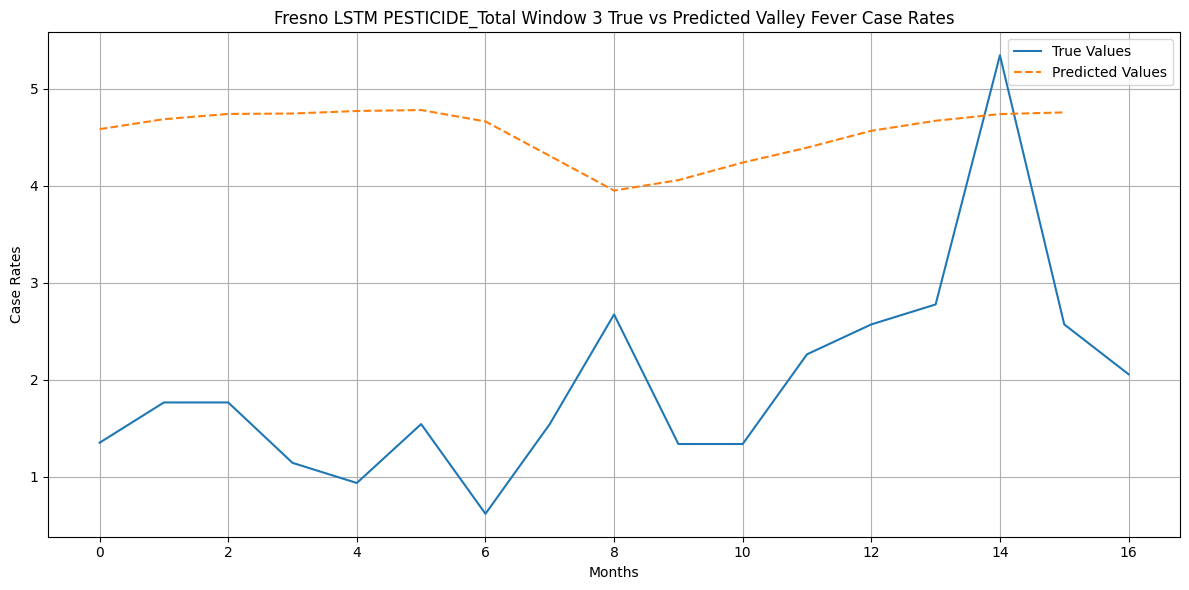

Epoch 1/300 - Training Loss 0.4780, Testing Loss 0.2373
Epoch 11/300 - Training Loss 0.3731, Testing Loss 0.1248
Epoch 21/300 - Training Loss 0.2444, Testing Loss 0.1436
Epoch 31/300 - Training Loss 0.2371, Testing Loss 0.2719
Epoch 41/300 - Training Loss 0.2224, Testing Loss 0.1690
Epoch 51/300 - Training Loss 0.2215, Testing Loss 0.2010
Epoch 61/300 - Training Loss 0.2232, Testing Loss 0.2187
Epoch 71/300 - Training Loss 0.2238, Testing Loss 0.1976
Epoch 81/300 - Training Loss 0.2232, Testing Loss 0.2082
Epoch 91/300 - Training Loss 0.2236, Testing Loss 0.2057
Epoch 101/300 - Training Loss 0.2226, Testing Loss 0.2052
Epoch 111/300 - Training Loss 0.2218, Testing Loss 0.2071
Epoch 121/300 - Training Loss 0.2227, Testing Loss 0.2045
Epoch 131/300 - Training Loss 0.2215, Testing Loss 0.2076
Epoch 141/300 - Training Loss 0.2208, Testing Loss 0.2054
Epoch 151/300 - Training Loss 0.2238, Testing Loss 0.2065
Epoch 161/300 - Training Loss 0.2253, Testing Loss 0.2060
Epoch 171/300 - Training 

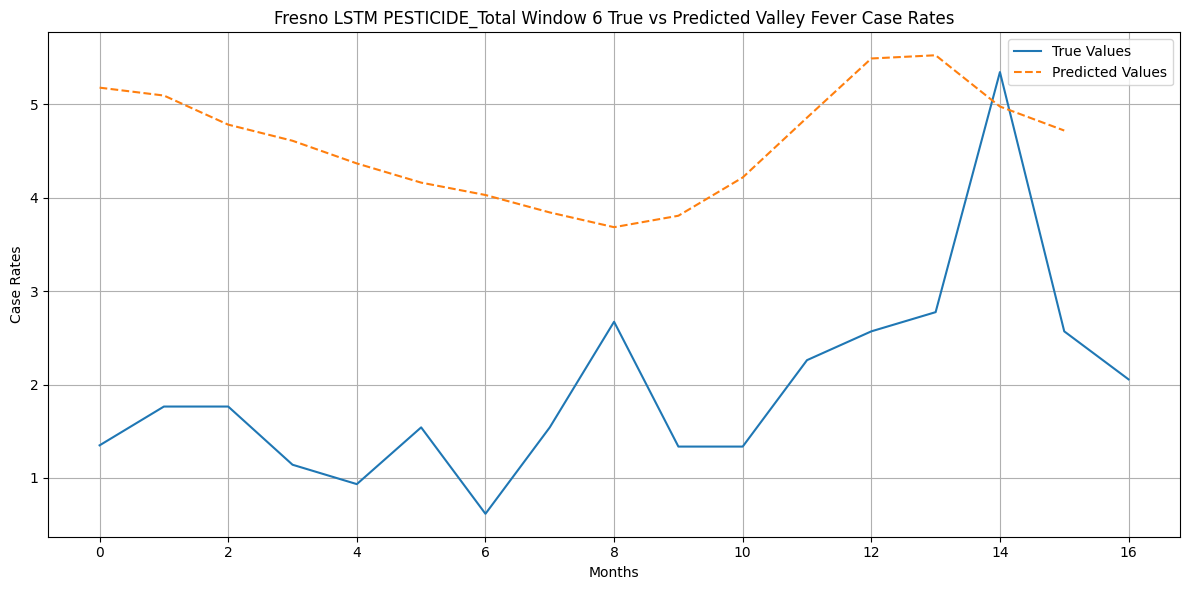

Epoch 1/300 - Training Loss 0.2836, Testing Loss 0.0844
Epoch 11/300 - Training Loss 0.2282, Testing Loss 0.1835
Epoch 21/300 - Training Loss 0.2292, Testing Loss 0.2332
Epoch 31/300 - Training Loss 0.2264, Testing Loss 0.1873
Epoch 41/300 - Training Loss 0.2264, Testing Loss 0.1899
Epoch 51/300 - Training Loss 0.2253, Testing Loss 0.2058
Epoch 61/300 - Training Loss 0.2255, Testing Loss 0.1987
Epoch 71/300 - Training Loss 0.2247, Testing Loss 0.1966
Epoch 81/300 - Training Loss 0.2252, Testing Loss 0.2009
Epoch 91/300 - Training Loss 0.2225, Testing Loss 0.1999
Epoch 101/300 - Training Loss 0.2223, Testing Loss 0.2001
Epoch 111/300 - Training Loss 0.2202, Testing Loss 0.2021
Epoch 121/300 - Training Loss 0.2196, Testing Loss 0.2002
Epoch 131/300 - Training Loss 0.2144, Testing Loss 0.1988
Epoch 141/300 - Training Loss 0.2167, Testing Loss 0.2015
Epoch 151/300 - Training Loss 0.2137, Testing Loss 0.2059
Epoch 161/300 - Training Loss 0.2157, Testing Loss 0.2009
Epoch 171/300 - Training 

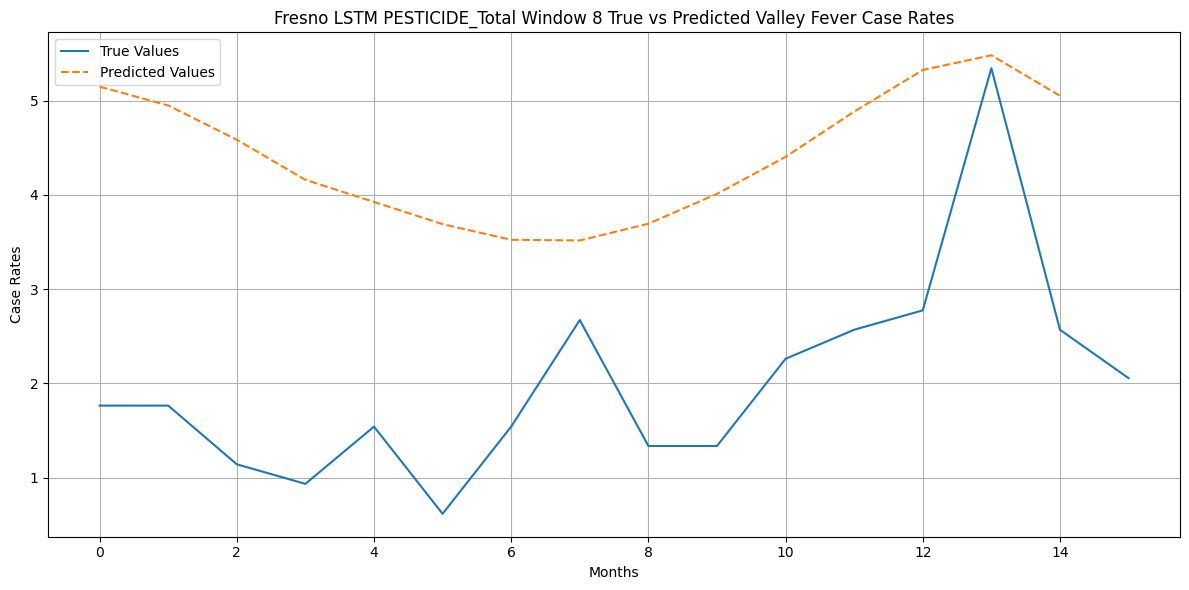

Epoch 1/300 - Training Loss 0.3991, Testing Loss 0.1578
Epoch 11/300 - Training Loss 0.2820, Testing Loss 0.0930
Epoch 21/300 - Training Loss 0.2424, Testing Loss 0.2767
Epoch 31/300 - Training Loss 0.2336, Testing Loss 0.1706
Epoch 41/300 - Training Loss 0.2335, Testing Loss 0.1835
Epoch 51/300 - Training Loss 0.2286, Testing Loss 0.2114
Epoch 61/300 - Training Loss 0.2291, Testing Loss 0.1905
Epoch 71/300 - Training Loss 0.2315, Testing Loss 0.1969
Epoch 81/300 - Training Loss 0.2316, Testing Loss 0.1976
Epoch 91/300 - Training Loss 0.2317, Testing Loss 0.1947
Epoch 101/300 - Training Loss 0.2295, Testing Loss 0.1987
Epoch 111/300 - Training Loss 0.2289, Testing Loss 0.1952
Epoch 121/300 - Training Loss 0.2321, Testing Loss 0.1964
Epoch 131/300 - Training Loss 0.2311, Testing Loss 0.1962
Epoch 141/300 - Training Loss 0.2282, Testing Loss 0.1966
Epoch 151/300 - Training Loss 0.2295, Testing Loss 0.1962
Epoch 161/300 - Training Loss 0.2253, Testing Loss 0.1984
Epoch 171/300 - Training 

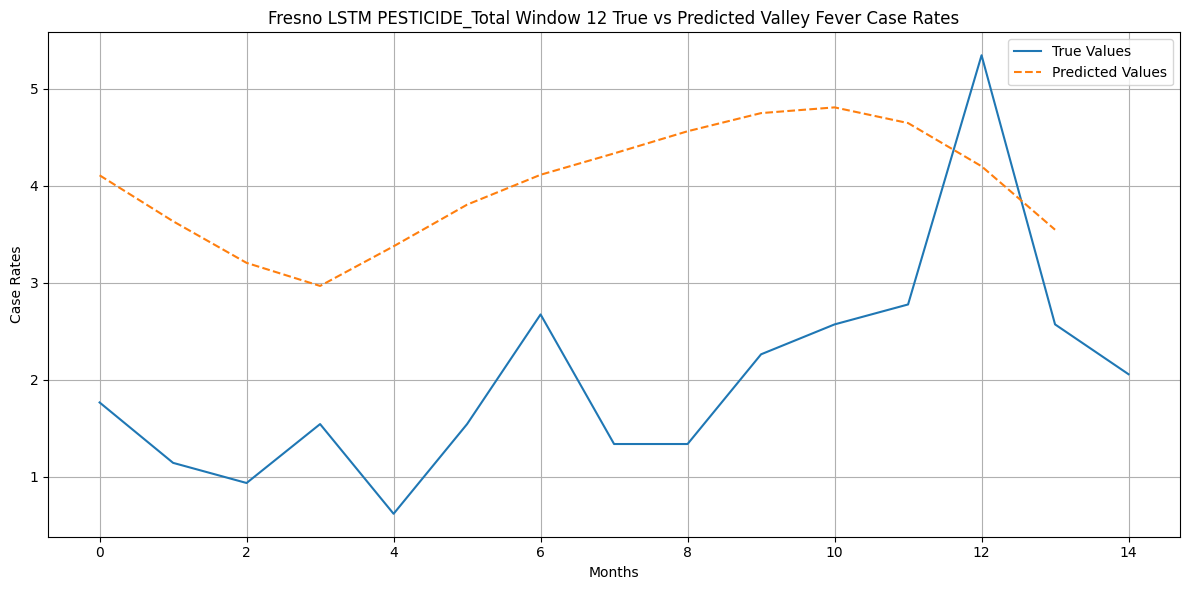

In [49]:
# now loop through each feature and sliding window size
for feature_index, feature in enumerate(feature_columns):
  # generate the feature vector and target vector
  for window_size in sliding_window_sizes:
    X_train, X_test, y_train, y_test = preprocess_data(X, y, feature_index, window_size)
    
    # scale the data
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = scale_data(X_train, X_test, y_train, y_test)
    
    # Convert to PyTorch tensors and reshape for LSTM input
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tensor  = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32).view(-1, 1)
    y_test_tensor  = torch.tensor(y_test_scaled, dtype=torch.float32).view(-1, 1)

    # Initialize the model
    model = LSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout)
    
    # Define optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Create Trainer instance
    trainer = TrainerNewNew(model, criterion, optimizer, scaler_y)
    
    # Train the model
    history, train_preds_inv, y_train_true = trainer.train(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, epochs)
    
    # Evaluate the model
    y_pred_inv, y_true_inv = trainer.evaluate(X_test_tensor, y_test_tensor)
    
    # Calculate RMSE for test set
    rmse = np.sqrt(np.mean((y_pred_inv - y_true_inv) ** 2))
    
    # Store results
    results.append({
        'feature': feature,
        'window_size': window_size,
        'rmse': rmse
    })
    
    print(f"Feature: {feature}, Window Size: {window_size}, Test RMSE: {rmse:.4f}")
    
    # Optionally visualize results for each run
    trainer.visualize_results(y_true_inv, y_pred_inv, county_name="Fresno", model_type="LSTM", title_text=f"{feature} Window {window_size}", show_plot=True, save_fig=False)

(87, 9)
Epoch 1/300 - Training Loss 0.2365, Testing Loss 0.1316
Epoch 11/300 - Training Loss 0.2217, Testing Loss 0.1725
Epoch 21/300 - Training Loss 0.2168, Testing Loss 0.2096
Epoch 31/300 - Training Loss 0.2161, Testing Loss 0.2228
Epoch 41/300 - Training Loss 0.2163, Testing Loss 0.2153
Epoch 51/300 - Training Loss 0.2162, Testing Loss 0.2083
Epoch 61/300 - Training Loss 0.2152, Testing Loss 0.2093
Epoch 71/300 - Training Loss 0.2156, Testing Loss 0.2134
Epoch 81/300 - Training Loss 0.2146, Testing Loss 0.2146
Epoch 91/300 - Training Loss 0.2139, Testing Loss 0.2142
Epoch 101/300 - Training Loss 0.2140, Testing Loss 0.2157
Epoch 111/300 - Training Loss 0.2136, Testing Loss 0.2170
Epoch 121/300 - Training Loss 0.2116, Testing Loss 0.2194
Epoch 131/300 - Training Loss 0.2108, Testing Loss 0.2203
Epoch 141/300 - Training Loss 0.2102, Testing Loss 0.2206
Epoch 151/300 - Training Loss 0.2115, Testing Loss 0.2221
Epoch 161/300 - Training Loss 0.2087, Testing Loss 0.2213
Epoch 171/300 - T

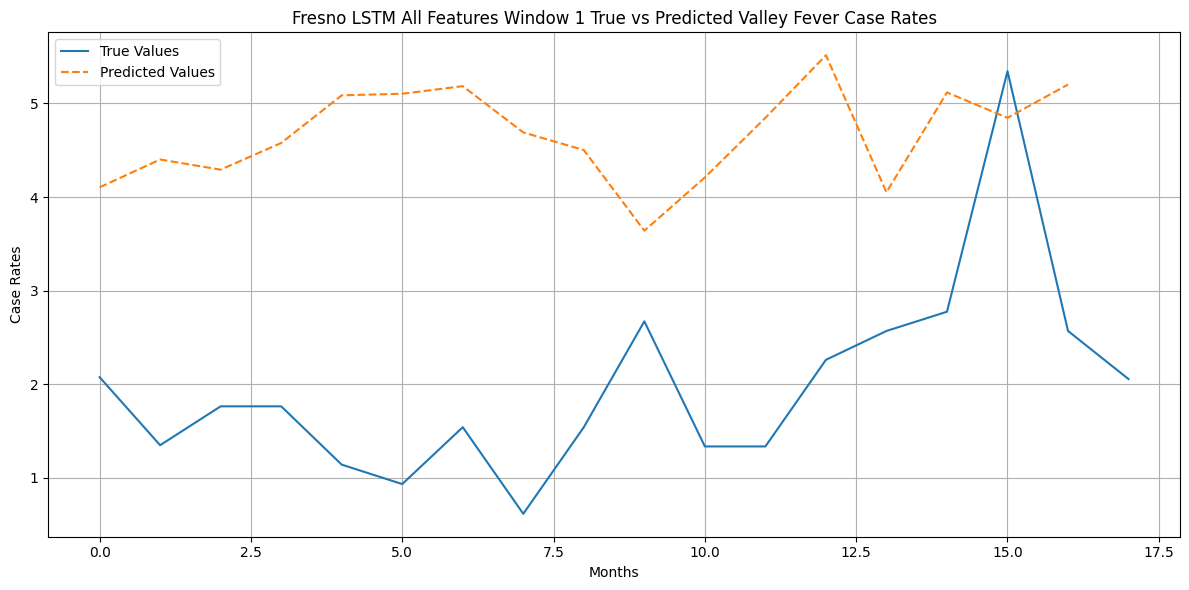

Epoch 1/300 - Training Loss 0.4278, Testing Loss 0.1830
Epoch 11/300 - Training Loss 0.3350, Testing Loss 0.0943
Epoch 21/300 - Training Loss 0.2419, Testing Loss 0.1311
Epoch 31/300 - Training Loss 0.2281, Testing Loss 0.2648
Epoch 41/300 - Training Loss 0.2175, Testing Loss 0.1987
Epoch 51/300 - Training Loss 0.2138, Testing Loss 0.1825
Epoch 61/300 - Training Loss 0.2171, Testing Loss 0.2121
Epoch 71/300 - Training Loss 0.2126, Testing Loss 0.2096
Epoch 81/300 - Training Loss 0.2100, Testing Loss 0.2029
Epoch 91/300 - Training Loss 0.2095, Testing Loss 0.2087
Epoch 101/300 - Training Loss 0.2094, Testing Loss 0.2066
Epoch 111/300 - Training Loss 0.2048, Testing Loss 0.2078
Epoch 121/300 - Training Loss 0.2017, Testing Loss 0.2091
Epoch 131/300 - Training Loss 0.1978, Testing Loss 0.2084
Epoch 141/300 - Training Loss 0.1963, Testing Loss 0.2089
Epoch 151/300 - Training Loss 0.1907, Testing Loss 0.2060
Epoch 161/300 - Training Loss 0.1868, Testing Loss 0.2060
Epoch 171/300 - Training 

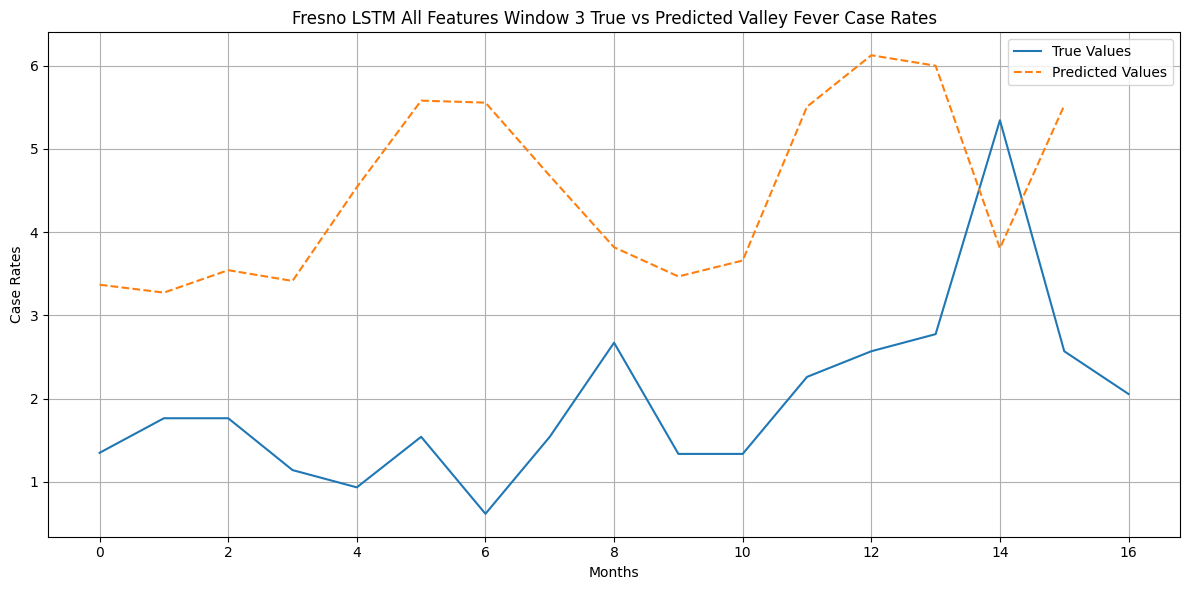

Epoch 1/300 - Training Loss 0.3923, Testing Loss 0.1401
Epoch 11/300 - Training Loss 0.2424, Testing Loss 0.1344
Epoch 21/300 - Training Loss 0.2324, Testing Loss 0.2663
Epoch 31/300 - Training Loss 0.2188, Testing Loss 0.1748
Epoch 41/300 - Training Loss 0.2160, Testing Loss 0.1929
Epoch 51/300 - Training Loss 0.2176, Testing Loss 0.2152
Epoch 61/300 - Training Loss 0.2148, Testing Loss 0.1939
Epoch 71/300 - Training Loss 0.2113, Testing Loss 0.2056
Epoch 81/300 - Training Loss 0.2010, Testing Loss 0.2025
Epoch 91/300 - Training Loss 0.1972, Testing Loss 0.2030
Epoch 101/300 - Training Loss 0.1868, Testing Loss 0.2011
Epoch 111/300 - Training Loss 0.1749, Testing Loss 0.1919
Epoch 121/300 - Training Loss 0.1596, Testing Loss 0.1786
Epoch 131/300 - Training Loss 0.1527, Testing Loss 0.1634
Epoch 141/300 - Training Loss 0.1498, Testing Loss 0.1341
Epoch 151/300 - Training Loss 0.1424, Testing Loss 0.1608
Epoch 161/300 - Training Loss 0.1409, Testing Loss 0.1351
Epoch 171/300 - Training 

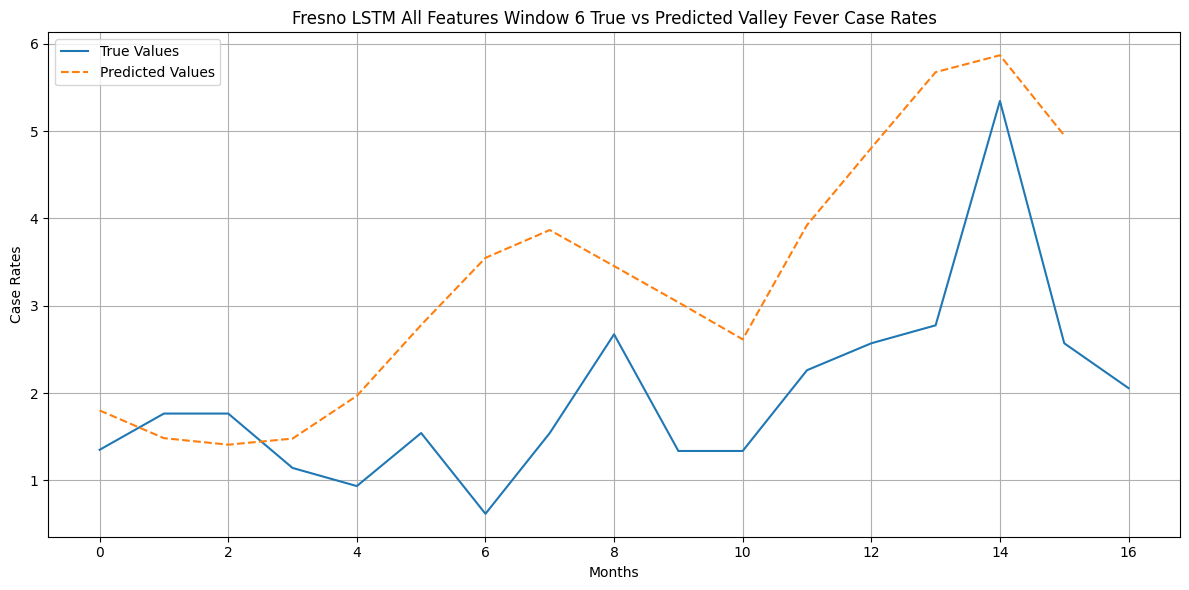

Epoch 1/300 - Training Loss 0.3589, Testing Loss 0.1151
Epoch 11/300 - Training Loss 0.2438, Testing Loss 0.1378
Epoch 21/300 - Training Loss 0.2339, Testing Loss 0.2522
Epoch 31/300 - Training Loss 0.2236, Testing Loss 0.1723
Epoch 41/300 - Training Loss 0.2217, Testing Loss 0.1885
Epoch 51/300 - Training Loss 0.2176, Testing Loss 0.2045
Epoch 61/300 - Training Loss 0.2149, Testing Loss 0.1818
Epoch 71/300 - Training Loss 0.2066, Testing Loss 0.1877
Epoch 81/300 - Training Loss 0.1945, Testing Loss 0.1736
Epoch 91/300 - Training Loss 0.1866, Testing Loss 0.1641
Epoch 101/300 - Training Loss 0.1724, Testing Loss 0.1534
Epoch 111/300 - Training Loss 0.1540, Testing Loss 0.1550
Epoch 121/300 - Training Loss 0.1494, Testing Loss 0.1467
Epoch 131/300 - Training Loss 0.1379, Testing Loss 0.1196
Epoch 141/300 - Training Loss 0.1305, Testing Loss 0.1163
Epoch 151/300 - Training Loss 0.1247, Testing Loss 0.1193
Epoch 161/300 - Training Loss 0.1118, Testing Loss 0.1164
Epoch 171/300 - Training 

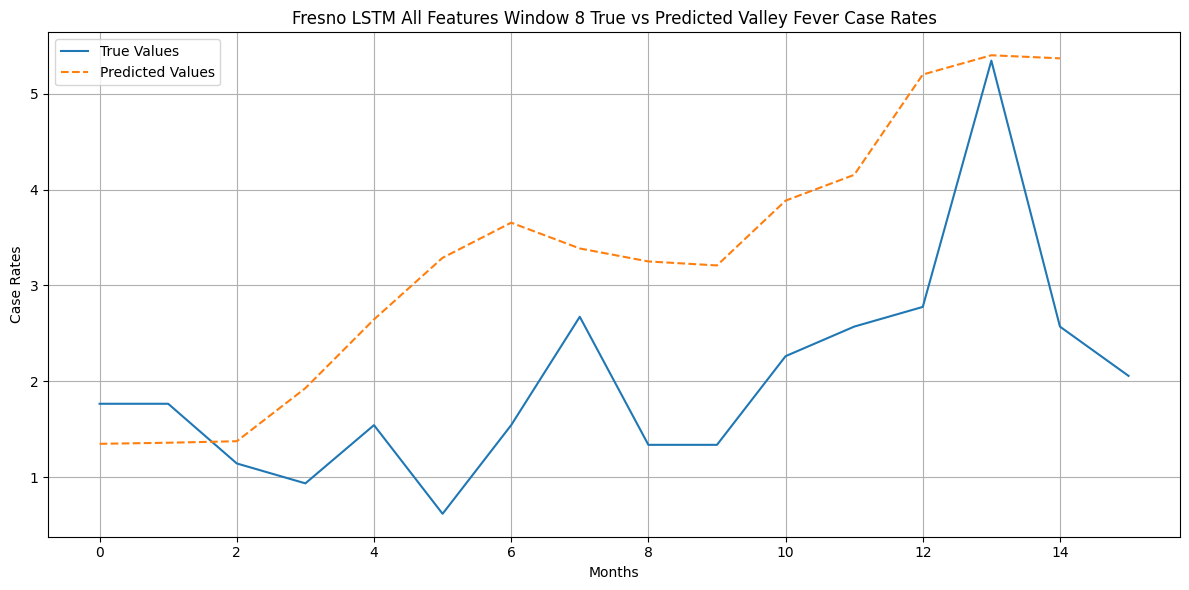

Epoch 1/300 - Training Loss 0.2595, Testing Loss 0.1168
Epoch 11/300 - Training Loss 0.2347, Testing Loss 0.2278
Epoch 21/300 - Training Loss 0.2290, Testing Loss 0.1848
Epoch 31/300 - Training Loss 0.2266, Testing Loss 0.1882
Epoch 41/300 - Training Loss 0.2180, Testing Loss 0.1902
Epoch 51/300 - Training Loss 0.1989, Testing Loss 0.1735
Epoch 61/300 - Training Loss 0.1754, Testing Loss 0.0829
Epoch 71/300 - Training Loss 0.1653, Testing Loss 0.0984
Epoch 81/300 - Training Loss 0.1507, Testing Loss 0.0733
Epoch 91/300 - Training Loss 0.1385, Testing Loss 0.0689
Epoch 101/300 - Training Loss 0.1205, Testing Loss 0.0643
Epoch 111/300 - Training Loss 0.0987, Testing Loss 0.0632
Epoch 121/300 - Training Loss 0.0860, Testing Loss 0.0603
Epoch 131/300 - Training Loss 0.0767, Testing Loss 0.0590
Epoch 141/300 - Training Loss 0.0774, Testing Loss 0.0602
Epoch 151/300 - Training Loss 0.0747, Testing Loss 0.0608
Epoch 161/300 - Training Loss 0.0707, Testing Loss 0.0592
Epoch 171/300 - Training 

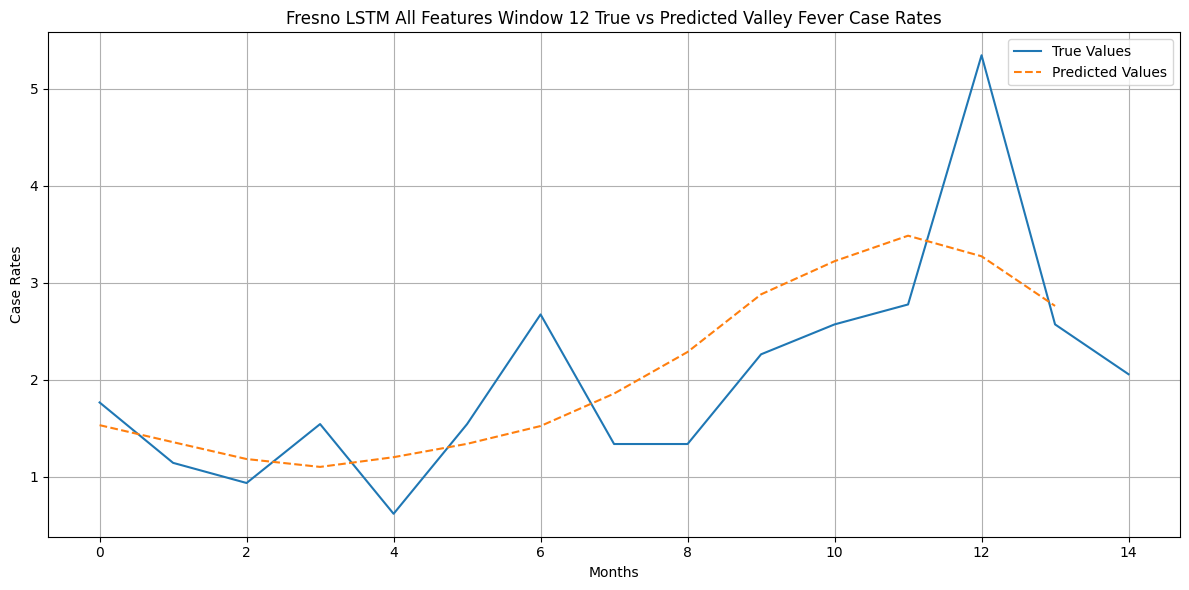

In [53]:
# using the code above, lets run the LSTM model on the full feature vector X with the sliding window varying
# vary the window size as well here
window_size = [1, 2, 4, 6, 8, 12] # change the index to vary the window size
# prep the data using the function you made 
print(X.shape)
for window_size in sliding_window_sizes:
    X_train, X_test, y_train, y_test = preprocess_data(X, y, feature_index=None, window_size=window_size)
    # scale the data
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = scale_data(X_train, X_test, y_train, y_test)
    # Convert to PyTorch tensors and reshape for LSTM input
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tensor  = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32).view(-1, 1)
    y_test_tensor  = torch.tensor(y_test_scaled, dtype=torch.float32).view(-1, 1) 
    # Initialize the model
    model = LSTM(input_size=len(feature_columns), hidden_size=hidden_size, num_layers=num_layers, dropout=dropout)
    # Define optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    # Create Trainer instance
    trainer = TrainerNewNew(model, criterion, optimizer, scaler_y)
    # Train the model
    history, train_preds_inv, y_train_true = trainer.train(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, epochs)
    # Evaluate the model
    y_pred_inv, y_true_inv = trainer.evaluate(X_test_tensor, y_test_tensor)
    # Calculate RMSE for test set
    rmse = np.sqrt(np.mean((y_pred_inv - y_true_inv) ** 2))
    # Store results
    results.append({
        'feature': 'All Features',
        'window_size': window_size,
        'rmse': rmse
    })  

    # visualize the output
    trainer.visualize_results(y_true_inv, y_pred_inv, county_name="Fresno", model_type="LSTM", title_text=f"All Features Window {window_size}", show_plot=True, save_fig=False) 

In [52]:
results_df = pd.DataFrame(results)
results_df

feature  window_size      rmse
0   FIRE_Acres_Burned            1  2.657675
1   FIRE_Acres_Burned            3  2.307065
2   FIRE_Acres_Burned            6  1.801622
3   FIRE_Acres_Burned            8  1.445858
4   FIRE_Acres_Burned           12  1.605555
5              PRECIP            1  2.758193
6              PRECIP            3  2.840481
7              PRECIP            6  2.564181
8              PRECIP            8  2.251446
9              PRECIP           12  1.009450
10    WIND_EventCount            1  2.872904
11    WIND_EventCount            3  2.877220
12    WIND_EventCount            6  2.851108
13    WIND_EventCount            8  2.743621
14    WIND_EventCount           12  2.311785
15        WIND_AvgMPH            1  2.828276
16        WIND_AvgMPH            3  2.706868
17        WIND_AvgMPH            6  2.716573
18        WIND_AvgMPH            8  2.503263
19        WIND_AvgMPH           12  6.380756
20      WIND_RunMiles            1  2.823866
21      WIND_RunMiles            3  2.713194
22      WIND_RunMiles            6  2.705813
23      WIND_RunMiles            8  2.494265
24      WIND_RunMiles           12  2.114261
25           AQI_PM25            1  2.700896
26           AQI_PM25            3  2.774329
27           AQI_PM25            6  3.088365
28           AQI_PM25            8  3.143041
29           AQI_PM25           12  2.913176
30           AQI_PM10            1  2.759871
31           AQI_PM10            3  2.710373
32           AQI_PM10            6  2.852912
33           AQI_PM10            8  2.484036
34           AQI_PM10           12  1.416370
35   EARTHQUAKE_Total            1  2.764024
36   EARTHQUAKE_Total            3  2.737790
37   EARTHQUAKE_Total            6  2.782782
38   EARTHQUAKE_Total            8  2.772101
39   EARTHQUAKE_Total           12  2.098830
40    PESTICIDE_Total            1  2.768897
41    PESTICIDE_Total            3  2.774276
42    PESTICIDE_Total            6  2.788367
43    PESTICIDE_Total            8  2.623492
44    PESTICIDE_Total           12  2.200803
45       All Features            1  2.849294
46       All Features            3  2.732174
47       All Features            6  1.740875
48       All Features            8  1.611256
49       All Features           12  0.774287

In [54]:
# save this data frame as a csv 
results_df.to_csv("../../data/fresno_lstm_feature_window_results.csv", index=False)

In [55]:
# for each feature, what is the sliding window that has the lowest RMSE?
best_results = results_df.loc[results_df.groupby('feature')['rmse'].idxmin()]
best_results

feature  window_size      rmse
34           AQI_PM10           12  1.416370
25           AQI_PM25            1  2.700896
49       All Features           12  0.774287
39   EARTHQUAKE_Total           12  2.098830
3   FIRE_Acres_Burned            8  1.445858
44    PESTICIDE_Total           12  2.200803
9              PRECIP           12  1.009450
18        WIND_AvgMPH            8  2.503263
14    WIND_EventCount           12  2.311785
24      WIND_RunMiles           12  2.114261

In [56]:
# save this as a csv as well
best_results.to_csv("../../data/fresno_lstm_best_feature_window_results.csv", index=False)